### In this study we perform a multiclass analysis combining both datasets - training2017 and ECGData.mat

In [1]:
# ==============================================================
# 1 – Imports + Global Config
# ==============================================================

import os
import math
import random
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.signal import resample_poly
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, LayerNormalization,
                                     MultiHeadAttention, GlobalAveragePooling1D, Dense, Dropout, Masking)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# --- Universal Seed ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --- Data Configuration ---
FS_TARGET   = 300  # Hz
MAX_LEN_SEC = 61   # Max signal length in seconds
MAX_LEN     = MAX_LEN_SEC * FS_TARGET  # Max length in samples (18,300)

In [2]:
# ==============================================================
# 2 – Shared Helper Functions
# ==============================================================

def zscore(x: np.ndarray) -> np.ndarray:
    """Applies z-score normalization to a signal."""
    return (x - x.mean()) / (x.std() + 1e-8)

def resample_to_target(x: np.ndarray, fs_src: int) -> np.ndarray:
    """Resamples a signal from its source sampling rate to the target rate."""
    if fs_src == FS_TARGET:
        return x
    gcd = math.gcd(fs_src, FS_TARGET)
    up = FS_TARGET // gcd
    down = fs_src // gcd
    return resample_poly(x, up, down)

--- Visualizing Resampling ---


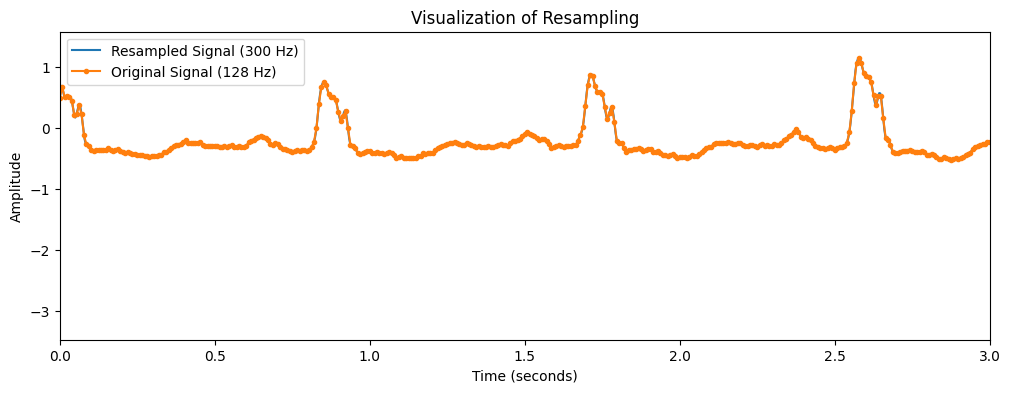

In [3]:
# ==============================================================
# VISUALIZATION: Resampling
# ==============================================================
print("--- Visualizing Resampling ---")
# Load one raw signal from ECGData.mat (128 Hz)
ecg_data_raw = loadmat('ECGData.mat')["ECGData"][0,0]["Data"]
signal_128hz = ecg_data_raw[96] # Example 'ARR' signal

# Resample it to 300 Hz
signal_300hz = resample_to_target(signal_128hz, fs_src=128)

# Plot the first few seconds to see the difference
fig, ax = plt.subplots(figsize=(12, 4))
time_128 = np.arange(len(signal_128hz)) / 128
time_300 = np.arange(len(signal_300hz)) / 300

ax.plot(time_300, signal_300hz, label='Resampled Signal (300 Hz)', zorder=1)
ax.plot(time_128, signal_128hz, '-o', markersize=3, label='Original Signal (128 Hz)', zorder=2)

ax.set_xlim(0, 3) # Show first 3 seconds
ax.set_title("Visualization of Resampling")
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Amplitude")
ax.legend()
plt.show()

In [4]:

# ==============================================================
# 3 – Load PhysioNet-2017 (Filtered for Normal/AF)
# ==============================================================

def load_physionet2017_filtered(root: str) -> Tuple[List[np.ndarray], List[int], List[str]]:
    ref = pd.read_csv(Path(root) / "REFERENCE.csv", header=None, names=["record", "label"])
    ref_filtered = ref[ref['label'].isin(['N', 'A'])].copy()
    map_to_binary = {"N": 0, "A": 1}
    sigs, ys, gids = [], [], []
    for rec, lbl in zip(ref_filtered.record, ref_filtered.label):
        mat = loadmat(Path(root) / f"{rec}.mat")["val"][0]
        sigs.append(zscore(mat.astype(np.float32)))
        ys.append(map_to_binary[lbl])
        gids.append(rec)
    return sigs, ys, gids

# ==============================================================
# 3b – Load ECGData.mat Subset (Corrected)
# ==============================================================

def load_ecgdata_binary(mat_path: str) -> Tuple[List[np.ndarray], List[int], List[str]]:
    d = loadmat(mat_path)["ECGData"][0, 0]
    signals = d["Data"]
    labels = [lbl[0] for lbl in d["Labels"][:, 0]]
    keep_mask = [lbl in ("NSR", "ARR", "CHF") for lbl in labels]
    signals = signals[keep_mask]
    labels = np.array(labels)[keep_mask]
    sigs, ys, gids = [], [], []
    for i, (sig_raw, lbl) in enumerate(zip(signals, labels)):
        resampled_sig = resample_to_target(sig_raw.astype(np.float32), fs_src=128)
        sigs.append(zscore(resampled_sig))
        ys.append(0 if lbl == "NSR" else 1)
        gids.append(f"ECGData_{i}")
    return sigs, ys, gids


In [5]:

# ==============================================================
# 4 – Build Final Dataset (WITH UNDERSAMPLING & PADDING)
# ==============================================================

def build_dataset() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    phys_root = "training2017"
    ecg_mat = "ECGData.mat"

    sig_a, y_a, gid_a = load_physionet2017_filtered(phys_root)
    sig_b, y_b, gid_b = load_ecgdata_binary(ecg_mat)

    # --- VISUALIZATION: Loaded Signals ---
    print("\n--- Visualizing Example Loaded Signals ---")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)
    ax1.plot(sig_a[0])
    ax1.set_title(f"Example from PhysioNet 2017 (Label: {y_a[0]}) - Length: {len(sig_a[0])}")
    ax2.plot(sig_b[0])
    ax2.set_title(f"Example from ECGData.mat (Label: {y_b[0]}) - Length: {len(sig_b[0])}")
    plt.suptitle("Signals After Loading and Resampling")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    initial_sigs = sig_a + sig_b
    initial_y = np.array(y_a + y_b)
    initial_g = np.array(gid_a + gid_b)

    # --- VISUALIZATION: Class Distribution Before Balancing ---
    print("\n--- Visualizing Class Imbalance ---")
    unique, counts = np.unique(initial_y, return_counts=True)
    plt.figure(figsize=(6,4))
    plt.bar(['Normal (0)', 'Arrhythmia (1)'], counts, color=['skyblue', 'salmon'])
    plt.title("Class Distribution Before Undersampling")
    plt.ylabel("Number of Signals")
    for i, count in enumerate(counts):
        plt.text(i, count + 50, str(count), ha='center')
    plt.show()

    # --- UNDERSAMPLING LOGIC ---
    idx_0 = np.where(initial_y == 0)[0]
    idx_1 = np.where(initial_y == 1)[0]
    n_minority = len(idx_1)
    np.random.shuffle(idx_0)
    idx_0_balanced = idx_0[:n_minority]
    final_indices = np.concatenate([idx_0_balanced, idx_1])
    np.random.shuffle(final_indices)

    balanced_sigs_list = [initial_sigs[i] for i in final_indices]
    y = initial_y[final_indices]
    g = initial_g[final_indices]

    # --- VISUALIZATION: Class Distribution After Balancing ---
    unique_balanced, counts_balanced = np.unique(y, return_counts=True)
    plt.figure(figsize=(6,4))
    plt.bar(['Normal (0)', 'Arrhythmia (1)'], counts_balanced, color=['skyblue', 'salmon'])
    plt.title("Class Distribution After Undersampling")
    plt.ylabel("Number of Signals")
    for i, count in enumerate(counts_balanced):
        plt.text(i, count + 10, str(count), ha='center')
    plt.show()

    # --- VISUALIZATION: Padding ---
    print("\n--- Visualizing Padding ---")
    short_signal_example = balanced_sigs_list[0]
    padded_signal_example = pad_sequences([short_signal_example], maxlen=MAX_LEN, dtype='float32', padding='post', truncating='post')[0]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    ax1.plot(short_signal_example)
    ax1.set_title(f"Original Signal (Length: {len(short_signal_example)})")
    ax2.plot(padded_signal_example)
    ax2.set_title(f"Padded Signal (Length: {len(padded_signal_example)})")
    plt.suptitle("Effect of Padding a Signal")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    X = pad_sequences(balanced_sigs_list, maxlen=MAX_LEN, dtype='float32', padding='post', truncating='post')
    X = np.expand_dims(X, axis=-1)
    
    print(f"\nFinal dataset shapes: X={X.shape}, y={y.shape}, groups={g.shape}")
    return X, y, g


In [6]:
# ==============================================================
# 5 – Transformer Model (MODIFIED FOR INTERPRETABILITY)
# ==============================================================

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    """A single transformer encoder block that correctly returns attention scores."""
    
    # Create the MultiHeadAttention layer first
    mha = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )
    
    # Pass return_attention_scores during the layer's CALL
    x, attention_scores = mha(
        query=inputs, 
        value=inputs,
        return_attention_scores=True
    )
    
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)

    ff_x = Dense(ff_dim, activation="relu")(x)
    ff_x = Dropout(dropout)(ff_x)
    ff_x = Dense(inputs.shape[-1])(ff_x)
    x = LayerNormalization(epsilon=1e-6)(x + ff_x)
    
    # Return both the processed sequence and the attention scores
    return x, attention_scores


def build_transformer_model(input_shape, head_size, num_heads, ff_dim,
                            num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    """Builds a transformer model that outputs both predictions and attention scores."""
    inputs = Input(shape=input_shape)
    x = inputs
    
    # --- 1. Patching Layer ---
    x = Conv1D(filters=32, kernel_size=80, strides=40, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Masking(mask_value=0.0)(x)
    
    # --- 2. Transformer Blocks ---
    attention_scores_list = []
    for i in range(num_transformer_blocks):
        x, scores = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
        attention_scores_list.append(scores)

    # --- 3. Classification Head ---
    x = GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    
    # Name the prediction output
    prediction_output = Dense(1, activation="sigmoid", name='prediction')(x)
    
    # Return the prediction and the attention scores from the LAST block
    return Model(inputs, [prediction_output, attention_scores_list[0], attention_scores_list[-1]])


--- Visualizing Example Loaded Signals ---


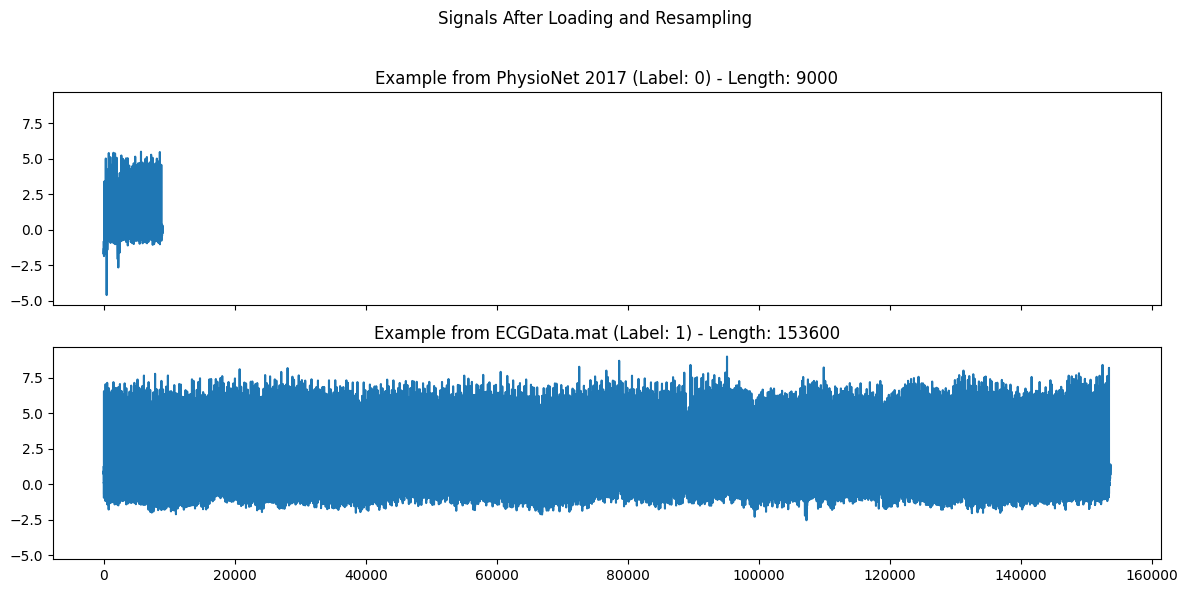


--- Visualizing Class Imbalance ---


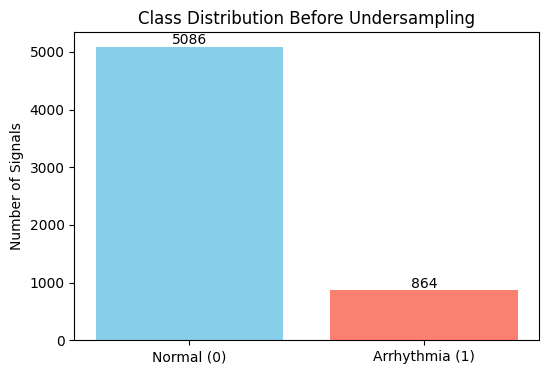

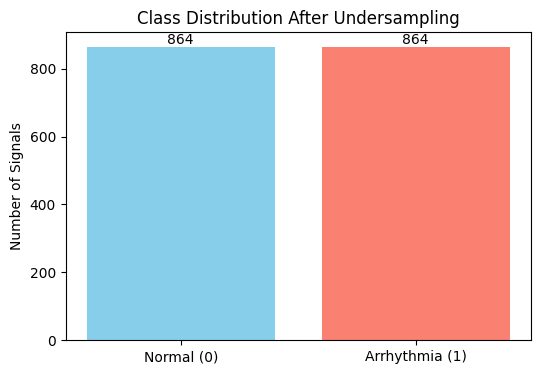


--- Visualizing Padding ---


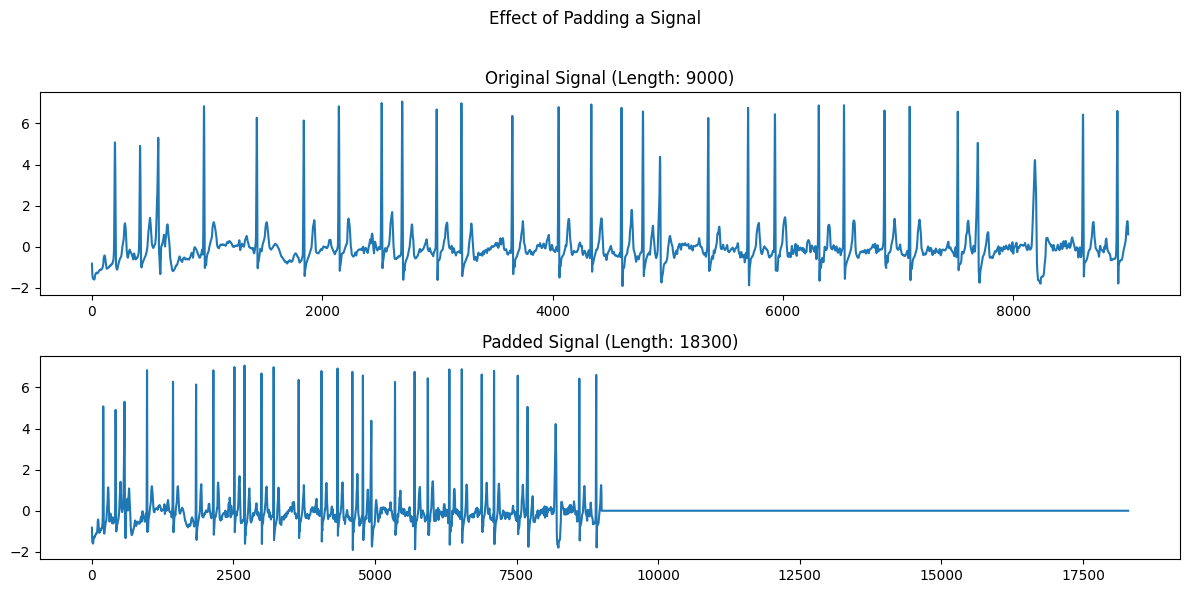


Final dataset shapes: X=(1728, 18300, 1), y=(1728,), groups=(1728,)
Positive class ratio: 0.500
Train size: 1036, Validation size: 346, Test size: 346


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 18300, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 458, 32)   │      2,592 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 458, 32)   │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 458, 32)   │          0 │ batch_normalizat… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 458, 32)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 458)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ [(None, 458, 32), │     33,568 │ masking[0][0],    │
│ (MultiHeadAttentio… │ (None, 2, 458,    │            │ any[0][0],        │
│                     │ 458)]             │            │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 458, 32)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 458, 32)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ masking[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 458, 32)   │         64 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 458, 4)    │        132 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 458, 4)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 458, 32)   │        160 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 458, 32)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 458, 32)   │         64 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ [(None, 458, 32), │     33,568 │ layer_normalizat… │
│ (MultiHeadAttentio… │ (None, 2, 458,    │            │ layer_normalizat… │
│                     │ 458)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 458, 32)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 458, 32)   │          0 │ dropout_4[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 72,873 (284.66 KB)

 Trainable params: 72,809 (284.41 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - loss: 0.7079 - prediction_accuracy: 0.5183 - prediction_auprc: 0.5615 - val_loss: 0.6711 - val_prediction_accuracy: 0.6590 - val_prediction_auprc: 0.6871
Epoch 2/50
  1/130 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - loss: 0.6184 - prediction_accuracy: 0.8750 - prediction_auprc: 0.9809

/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auprc` which is not available. Available metrics are: loss,prediction_accuracy,prediction_auprc,val_loss,val_prediction_accuracy,val_prediction_auprc
  current = self.get_monitor_value(logs)


130/130 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - loss: 0.6534 - prediction_accuracy: 0.6299 - prediction_auprc: 0.6784 - val_loss: 0.6508 - val_prediction_accuracy: 0.6618 - val_prediction_auprc: 0.7205
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - loss: 0.6427 - prediction_accuracy: 0.6276 - prediction_auprc: 0.6694 - val_loss: 0.6321 - val_prediction_accuracy: 0.6908 - val_prediction_auprc: 0.7454
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - loss: 0.6446 - prediction_accuracy: 0.6253 - prediction_auprc: 0.6716 - val_loss: 0.6099 - val_prediction_accuracy: 0.6821 - val_prediction_auprc: 0.7675
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - loss: 0.6334 - prediction_accuracy: 0.6572 - prediction_auprc: 0.6861 - val_loss: 0.5996 - val_prediction_accuracy: 0.6879 - val_prediction_auprc: 0.7807
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - loss: 0.6141 - prediction_accuracy: 0.6648 - prediction_auprc: 0.7358 - val_loss: 0.5927 - val_prediction_accu

In [7]:
# ==============================================================
# 6 – Split, Train, Evaluate
# ==============================================================
# --- Build the dataset ---
X, y, groups = build_dataset()
print(f"Positive class ratio: {y.mean():.3f}")

# --- Patient-Aware Split ---
gss_test = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_val_idx, test_idx = next(gss_test.split(X, y, groups))
X_tv, y_tv, g_tv = X[train_val_idx], y[train_val_idx], groups[train_val_idx]
X_te, y_te, g_te = X[test_idx], y[test_idx], groups[test_idx]

gss_val = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED)
train_idx, val_idx = next(gss_val.split(X_tv, y_tv, g_tv))
X_tr, y_tr = X_tv[train_idx], y_tv[train_idx]
X_va, y_va = X_tv[val_idx], y_tv[val_idx]

print(f"Train size: {len(X_tr)}, Validation size: {len(X_va)}, Test size: {len(X_te)}")

# --- Build, Compile, and Train the Model ---
model = build_transformer_model(
    input_shape=(MAX_LEN, 1),
    head_size=128,             # Smaller dimension
    num_heads=2,               # Fewer heads
    ff_dim=4,
    num_transformer_blocks=2,  # Fewer blocks
    mlp_units=[64],            # Smaller dense layer
    dropout=0.1,
    mlp_dropout=0.2
)

# Transformers often benefit from a lower learning rate
optimizer = Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss=['binary_crossentropy', None, None],  # Provide a loss for each of the 2 outputs
    loss_weights=[1.0, 0.0, 0.0],             # Apply weight only to the first loss
    metrics={'prediction': ['accuracy', tf.keras.metrics.AUC(curve='PR', name='auprc')]}
)

model.summary() # Check the new, shorter sequence length here!

cb_es = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True,
                                         monitor='val_auprc', mode='max')

# Using tf.data.Dataset for efficiency with a SMALLER BATCH SIZE
train_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_tr)).batch(8)
val_ds = tf.data.Dataset.from_tensor_slices((X_va, y_va)).batch(8)
test_ds = tf.data.Dataset.from_tensor_slices((X_te, y_te)).batch(8)

history = model.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds,
                    callbacks=[cb_es],
                    verbose=1)

In [8]:
# ==============================================================
# 7 – Final Evaluation on Test Set (CORRECTED)
# ==============================================================
print("\n--- Evaluating on Test Set ---")

results = model.evaluate(test_ds, return_dict=True)
print("Evaluation metrics:", results)

# Get the metrics by their names from the returned dictionary
acc = results['prediction_accuracy']
auprc = results['prediction_auprc']

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test AUPRC: {auprc:.4f}")


# model.predict() now returns a list of outputs: [predictions, attention_scores]
# We only need the first item from the list for our report.
prediction_output, _, _ = model.predict(test_ds)
y_pred_prob = prediction_output.ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_te, y_pred))

print("\nClassification Report:")
print(classification_report(y_te, y_pred, digits=4))


--- Evaluating on Test Set ---
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.5084 - prediction_accuracy: 0.8145 - prediction_auprc: 0.8803
Evaluation metrics: {'loss': 0.567199170589447, 'prediction_accuracy': 0.7976878881454468, 'prediction_auprc': 0.8443946242332458}

Test Accuracy: 0.7977
Test AUPRC: 0.8444
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step

Confusion Matrix:
[[141  38]
 [ 32 135]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8150    0.7877    0.8011       179
           1     0.7803    0.8084    0.7941       167

    accuracy                         0.7977       346
   macro avg     0.7977    0.7980    0.7976       346
weighted avg     0.7983    0.7977    0.7977       346




Visualizing attention for test sample #0 (Arrhythmia)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


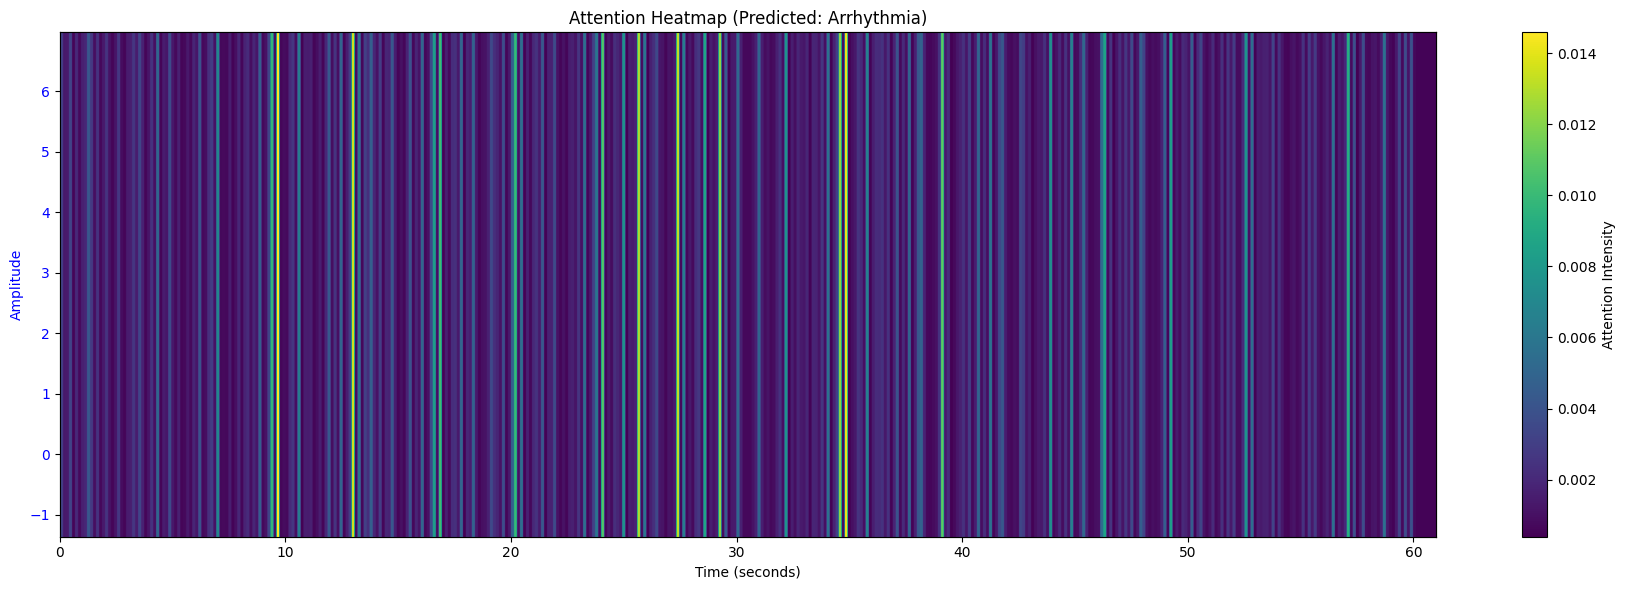


Visualizing attention for test sample #2 (Normal)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


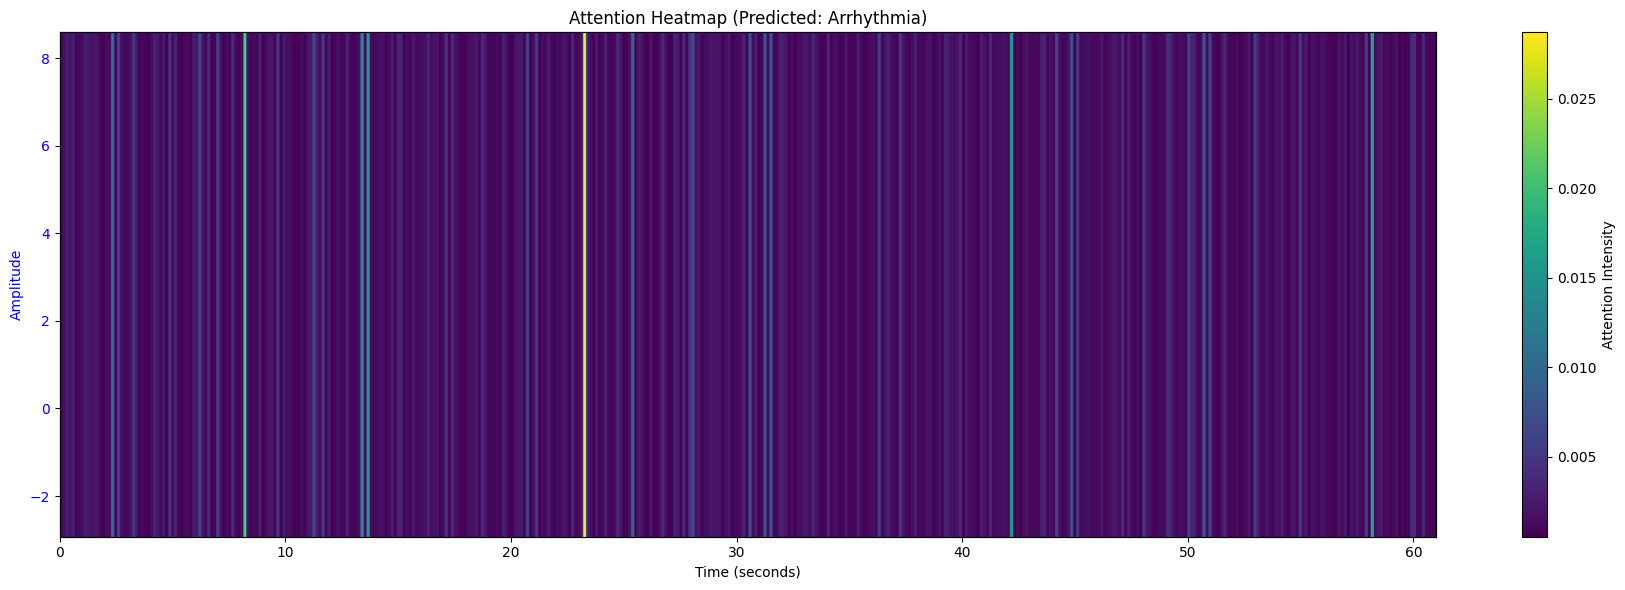

In [10]:
# ==============================================================
# 8 – INTERPRETABILITY: VISUALIZE ATTENTION
# ==============================================================

def plot_attention_heatmap(model, ecg_signal, stride=40):
    """
    Runs a single ECG signal through the model and plots the attention
    scores from the last transformer block as a heatmap over the signal.
    """
    # Add a batch dimension and make a prediction
    ecg_signal_batch = np.expand_dims(ecg_signal, axis=0)
    prediction, _ ,attention_scores = model.predict(ecg_signal_batch)
    
    # Process the attention scores
    # Shape: (batch, heads, seq_len, seq_len) -> (1, 2, 458, 458)
    # Average the scores across all attention heads
    avg_attention_scores = np.mean(attention_scores[0], axis=0)
    
    # To get a single "importance" score for each patch, we average the attention
    # it received from all other patches.
    patch_importance = np.mean(avg_attention_scores, axis=0)
    
    # Repeat the patch scores to match the original signal's length
    # This stretches our 458 importance scores back out to the signal dimension
    attention_heatmap = np.repeat(patch_importance, stride)
    # Pad to match original MAX_LEN if necessary
    padding_needed = MAX_LEN - len(attention_heatmap)
    if padding_needed > 0:
        attention_heatmap = np.pad(attention_heatmap, (0, padding_needed), 'constant')

    predicted_class = "Arrhythmia" if prediction[0][0] > 0.5 else "Normal"
    
    # --- Create the plot ---
    fig, ax1 = plt.subplots(figsize=(18, 6))
    
    # Plot the ECG signal
    time = np.arange(MAX_LEN) / FS_TARGET
    ax1.plot(time, ecg_signal, color='blue', label='ECG Signal')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Amplitude', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title(f'Attention Heatmap (Predicted: {predicted_class})')

    # Create a second y-axis for the attention heatmap
    ax2 = ax1.twinx()
    # Use a heatmap-like visualization for the attention scores
    im = ax2.imshow(
        attention_heatmap[np.newaxis, :], 
        aspect='auto', 
        cmap='viridis', 
        extent=[time[0], time[-1], 0, 1]
    )
    ax2.set_yticks([])
    cbar = fig.colorbar(im, pad=0.05, ax=ax2)
    cbar.set_label('Attention Intensity')

    fig.tight_layout()
    plt.show()

# --- Example Usage ---
# Select a sample from the test set to visualize
# Let's pick an arrhythmia case to see what the model focuses on
arrhythmia_indices = np.where(y_te == 1)[0]
if len(arrhythmia_indices) > 0:
    sample_idx = arrhythmia_indices[0]
    print(f"\nVisualizing attention for test sample #{sample_idx} (Arrhythmia)")
    plot_attention_heatmap(model, X_te[sample_idx])
else:
    print("\nNo arrhythmia samples found in the test set to visualize.")

# And a normal case for comparison
normal_indices = np.where(y_te == 0)[0]
if len(normal_indices) > 0:
    sample_idx = normal_indices[0]
    print(f"\nVisualizing attention for test sample #{sample_idx} (Normal)")
    plot_attention_heatmap(model, X_te[sample_idx])
else:
    print("\nNo normal samples found in the test set to visualize.")


--- Visualizing Misclassifications with Intensity Heatmap ---

Visualizing False Negative Sample (Test Index: 36)


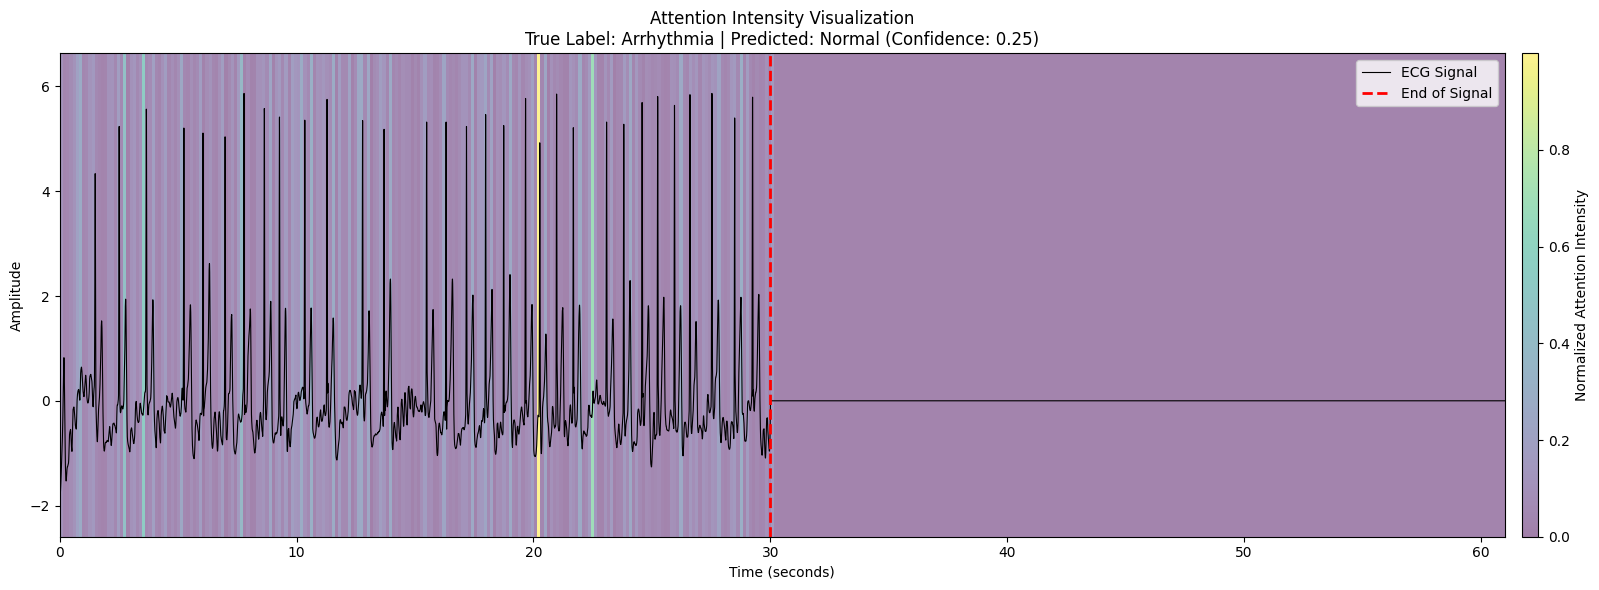

In [18]:
# ==============================================================
# 9 – ENHANCED VISUALIZATION WITH INTENSITY
# ==============================================================

def plot_attention_heatmap_intensity(model, ecg_signal, true_label, stride=40):
    """
    An improved visualization that uses a background heatmap to show
    attention intensity without obscuring the signal.
    """
    # --- 1. Get Prediction and Attention Scores ---
    ecg_signal_batch = np.expand_dims(ecg_signal, axis=0)
    prediction, _ ,attention_scores = model.predict(ecg_signal_batch, verbose=0)
    
    # --- 2. Process Attention Scores ---
    avg_attention_scores = np.mean(attention_scores[0], axis=0)
    patch_importance = np.mean(avg_attention_scores, axis=0)
    
    # Normalize patch importance to be between 0 and 1
    patch_importance_normalized = (patch_importance - np.min(patch_importance)) / (np.max(patch_importance) - np.min(patch_importance) + 1e-8)
    
    attention_heatmap = np.repeat(patch_importance_normalized, stride)
    attention_heatmap = attention_heatmap[:MAX_LEN]

    # --- 3. Find End of Real Signal ---
    squeezed_signal = ecg_signal.squeeze()
    try:
        last_real_index = np.where(squeezed_signal != 0)[0][-1]
        end_of_signal_time = last_real_index / FS_TARGET
    except IndexError:
        end_of_signal_time = MAX_LEN_SEC

    # --- 4. Create the Plot ---
    predicted_class = "Arrhythmia" if prediction[0][0] > 0.5 else "Normal"
    true_class = "Arrhythmia" if true_label == 1 else "Normal"
    title = (
        f"Attention Intensity Visualization\n"
        f"True Label: {true_class} | Predicted: {predicted_class} "
        f"(Confidence: {prediction[0][0]:.2f})"
    )
    
    fig, ax = plt.subplots(figsize=(18, 6))
    time = np.arange(MAX_LEN) / FS_TARGET
    
    # --- NEW: Plot heatmap in the background ---
    # Create a 2D array for the heatmap image
    heatmap_2d = np.tile(attention_heatmap, (10, 1))
    
    # Get the y-axis limits from the signal plot itself
    min_val, max_val = np.min(squeezed_signal), np.max(squeezed_signal)
    y_pad = (max_val - min_val) * 0.1 # Add 10% padding
    
    im = ax.imshow(
        heatmap_2d,
        aspect='auto',
        cmap='viridis',
        interpolation='nearest',
        extent=[time[0], time[-1], min_val - y_pad, max_val + y_pad],
        alpha=0.5 # Make the heatmap semi-transparent
    )

    # Plot the ECG signal ON TOP of the heatmap
    ax.plot(time, squeezed_signal, color='black', linewidth=0.8, label='ECG Signal')
    
    # Add a colorbar for the heatmap
    cbar = fig.colorbar(im, ax=ax, pad=0.01, aspect=30)
    cbar.set_label('Normalized Attention Intensity')
    
    ax.axvline(x=end_of_signal_time, color='r', linestyle='--', linewidth=2, label='End of Signal')
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.set_xlim(0, MAX_LEN_SEC)
    
    fig.tight_layout()
    plt.show()

# --- Example Usage for the Intensity Plot ---
# (You can use this to replace the usage in the misclassification section)
print("\n--- Visualizing Misclassifications with Intensity Heatmap ---")
# Find misclassified False Negatives
fn_indices = np.where((y_pred == 0) & (y_te == 1))[0]
if len(fn_indices) > 0:
    sample_idx = fn_indices[0]
    print(f"\nVisualizing False Negative Sample (Test Index: {sample_idx})")
    plot_attention_heatmap_intensity(model, X_te[sample_idx], y_te[sample_idx])
else:
    print("No False Negative errors to visualize.")


--- Running Head-by-Head Visualization for Multiple Samples ---

Visualizing Arrhythmia Sample #1 (Test Index: 0)


/var/folders/hl/n8ld50fn44bgmz1x9g35k1800000gn/T/ipykernel_86393/2735863172.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])


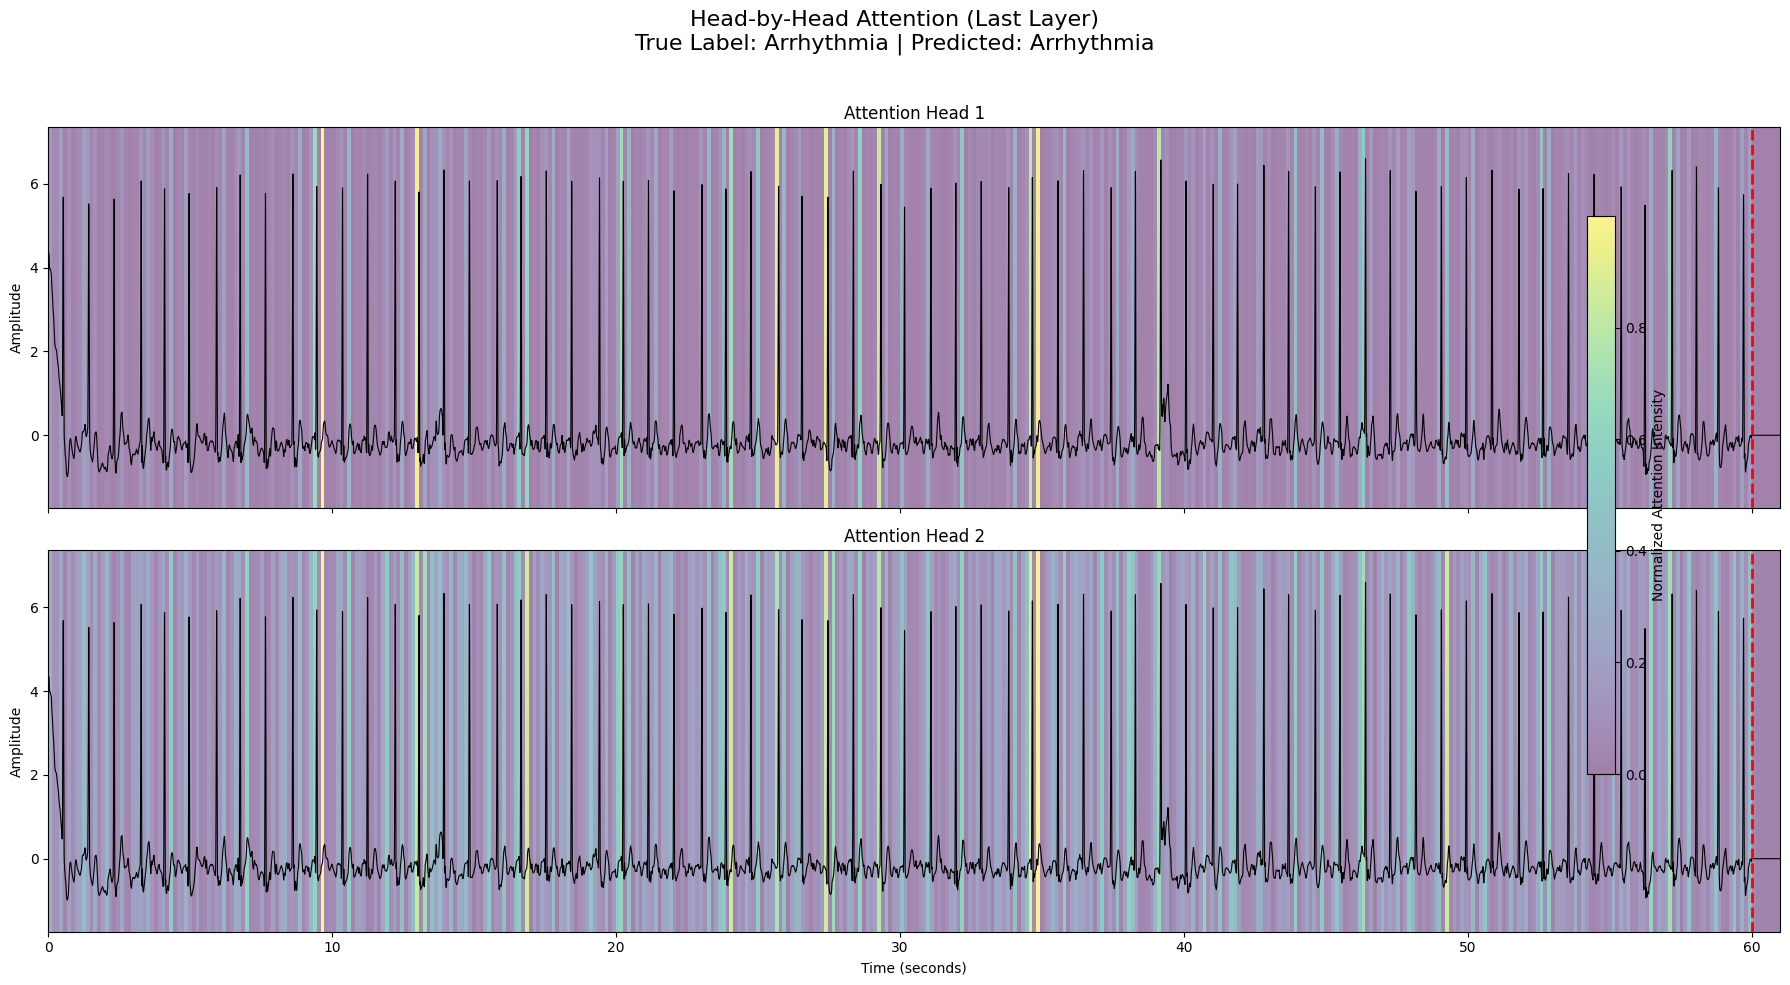


Visualizing Arrhythmia Sample #2 (Test Index: 1)


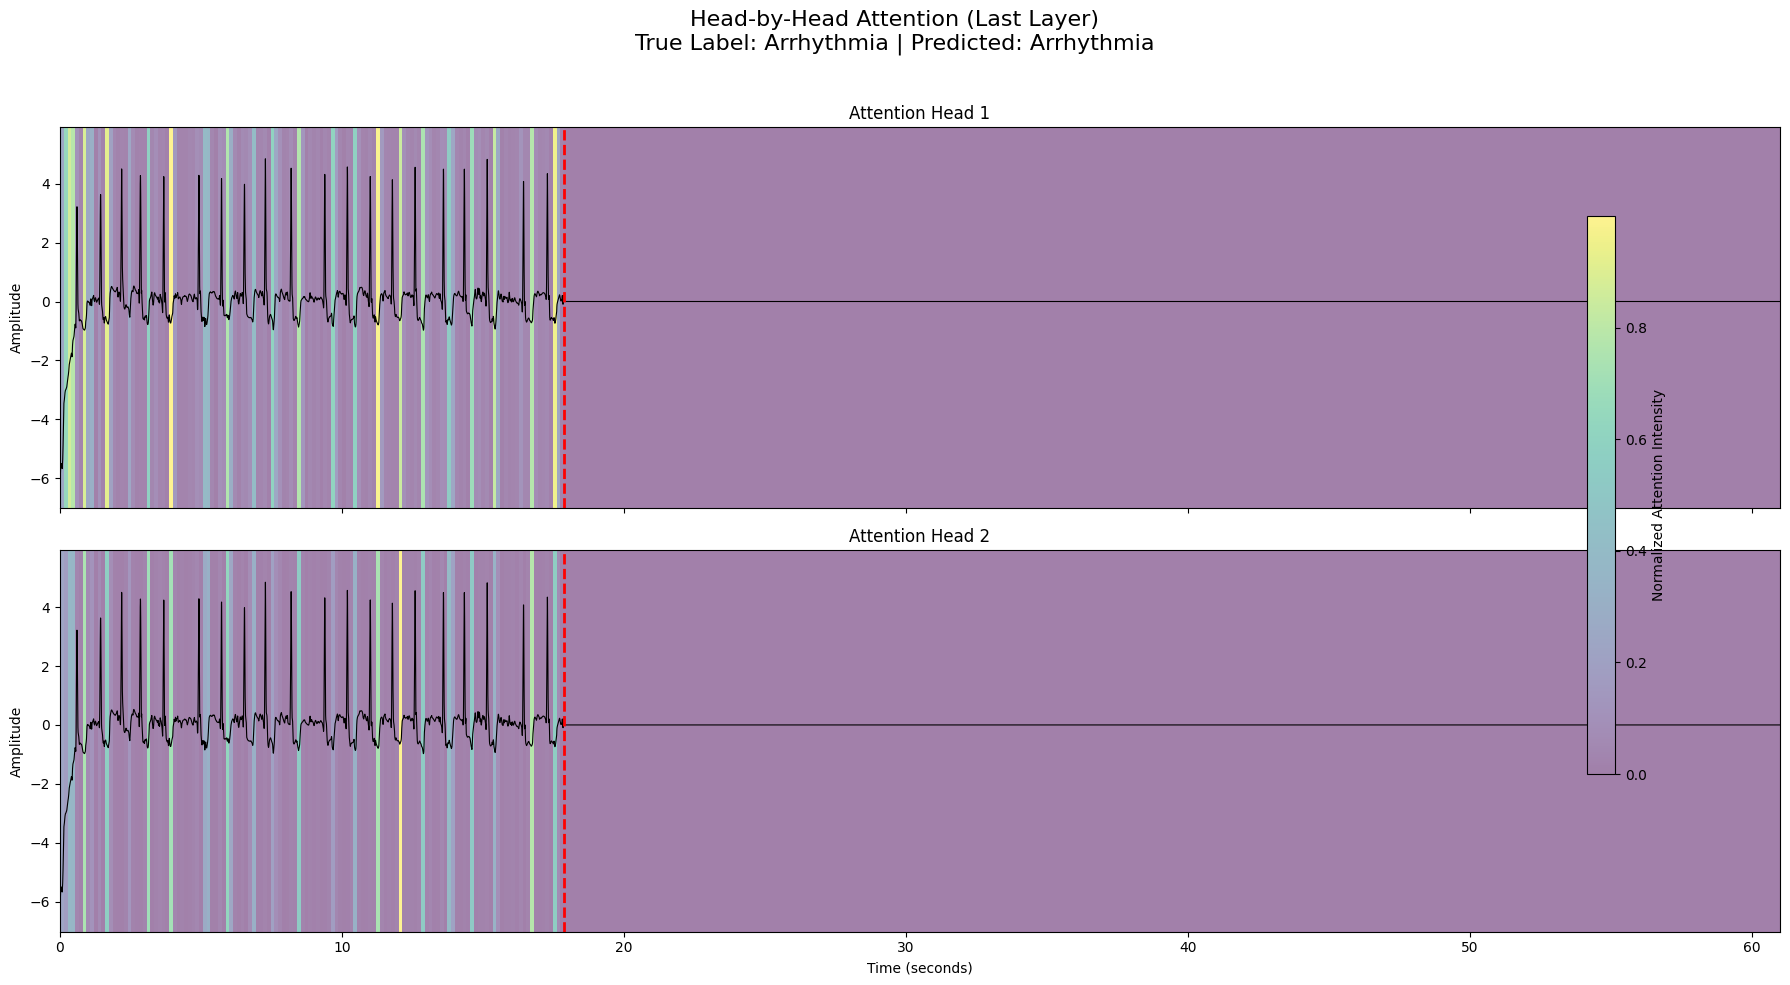


Visualizing Arrhythmia Sample #3 (Test Index: 3)


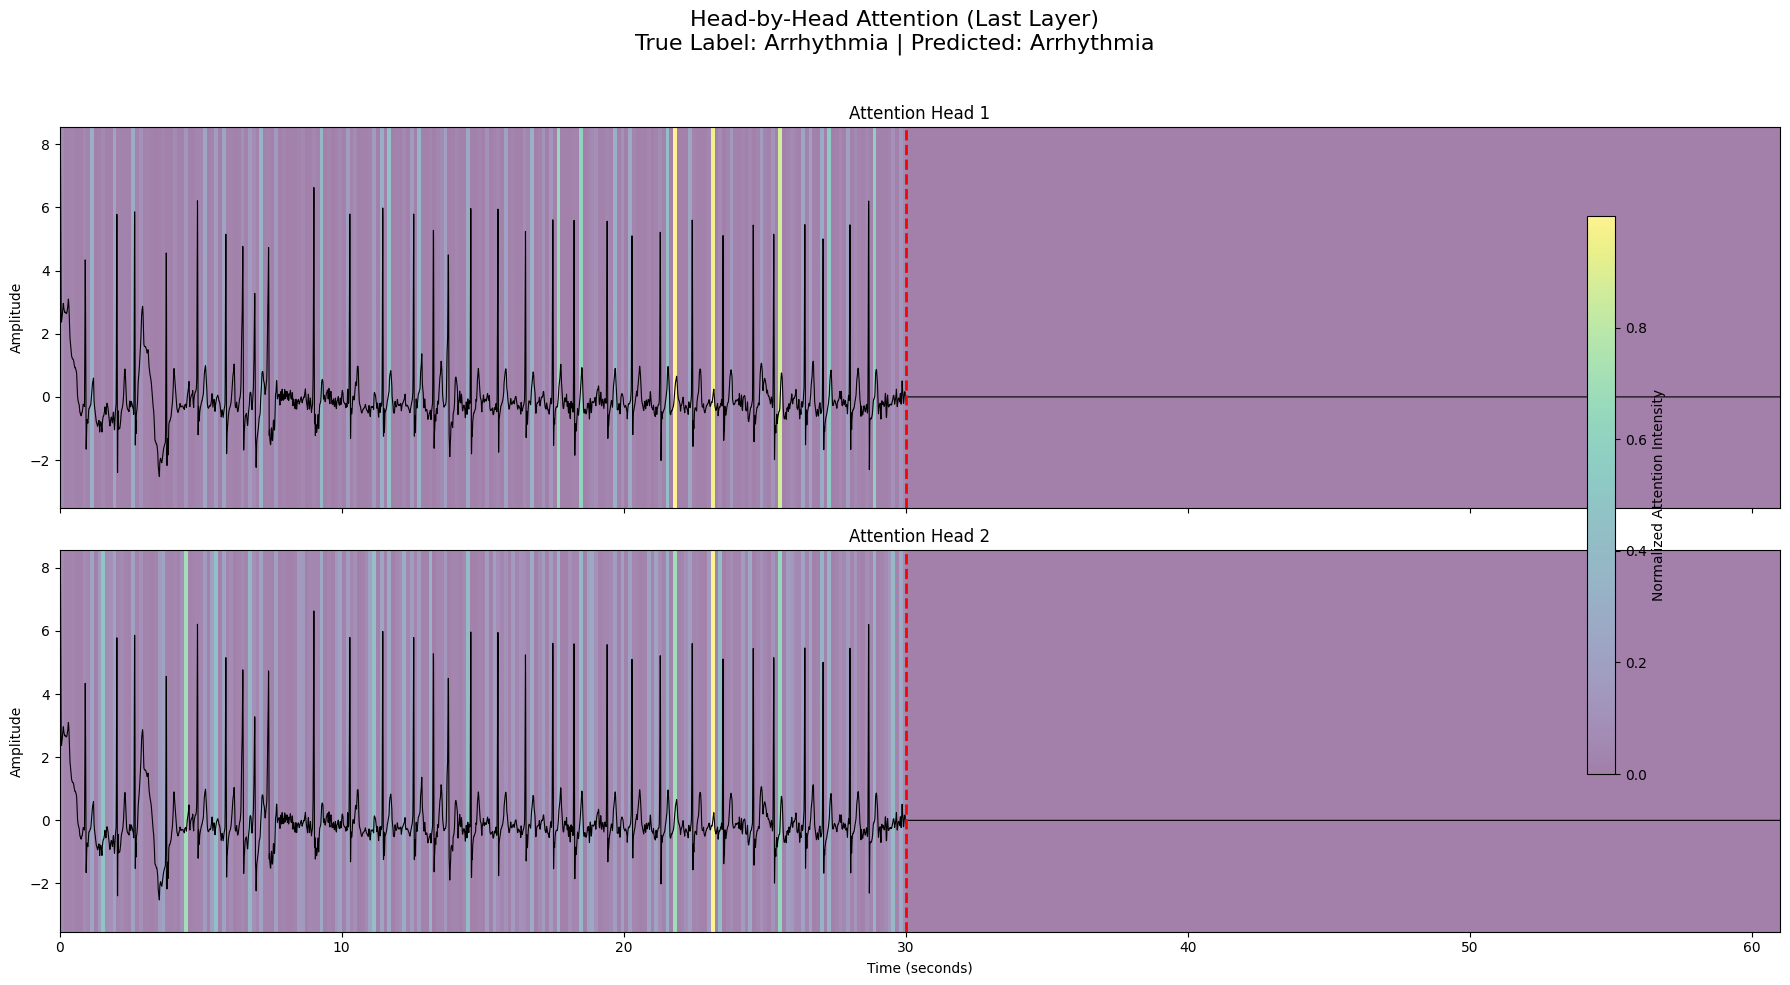


Visualizing Normal Sample #1 (Test Index: 2)


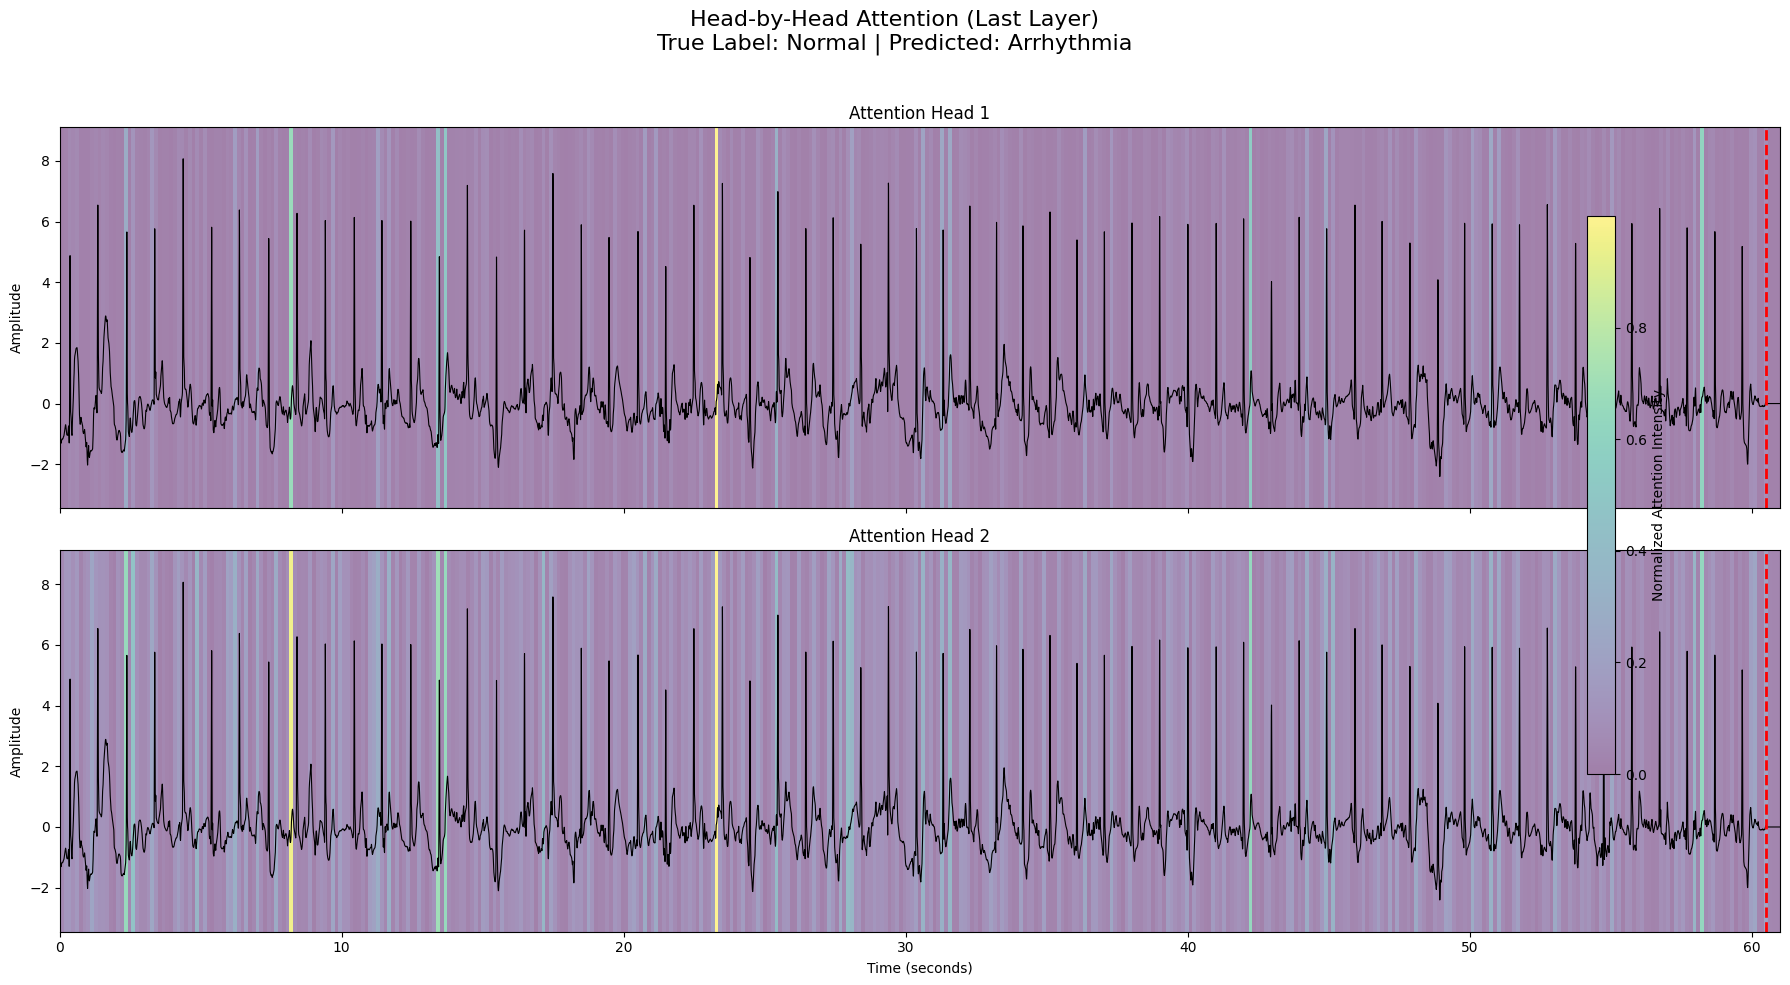


Visualizing Normal Sample #2 (Test Index: 4)


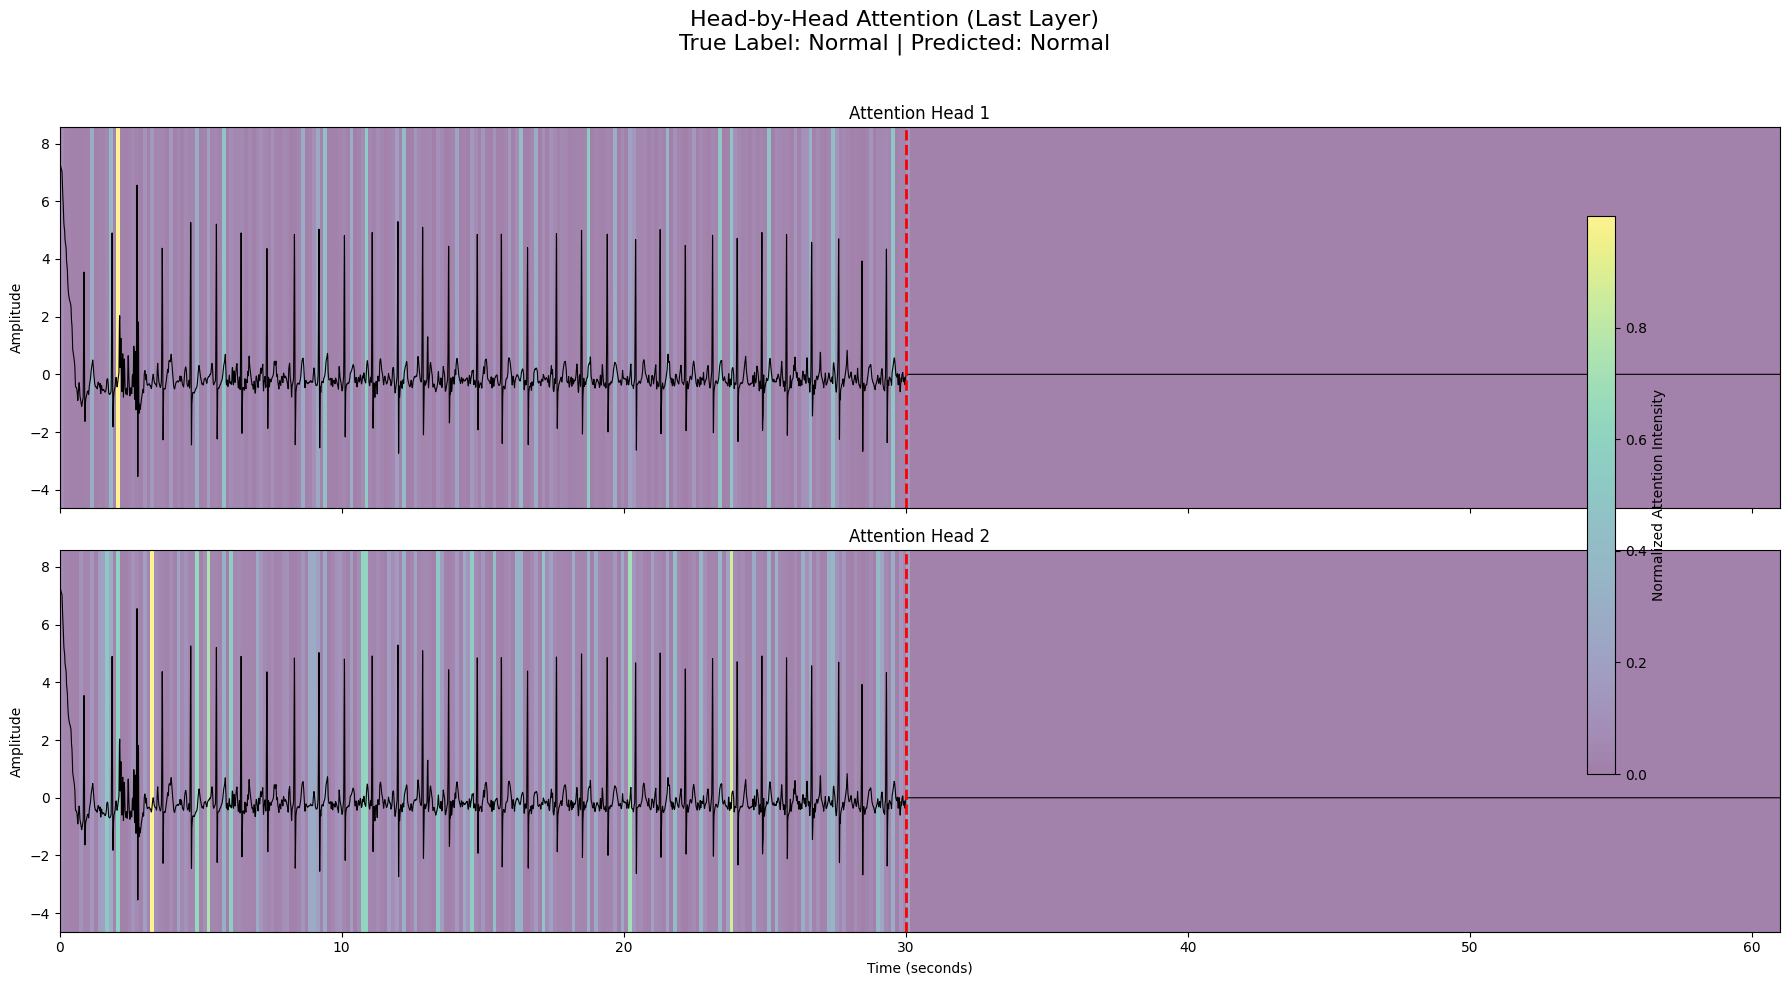


Visualizing Normal Sample #3 (Test Index: 5)


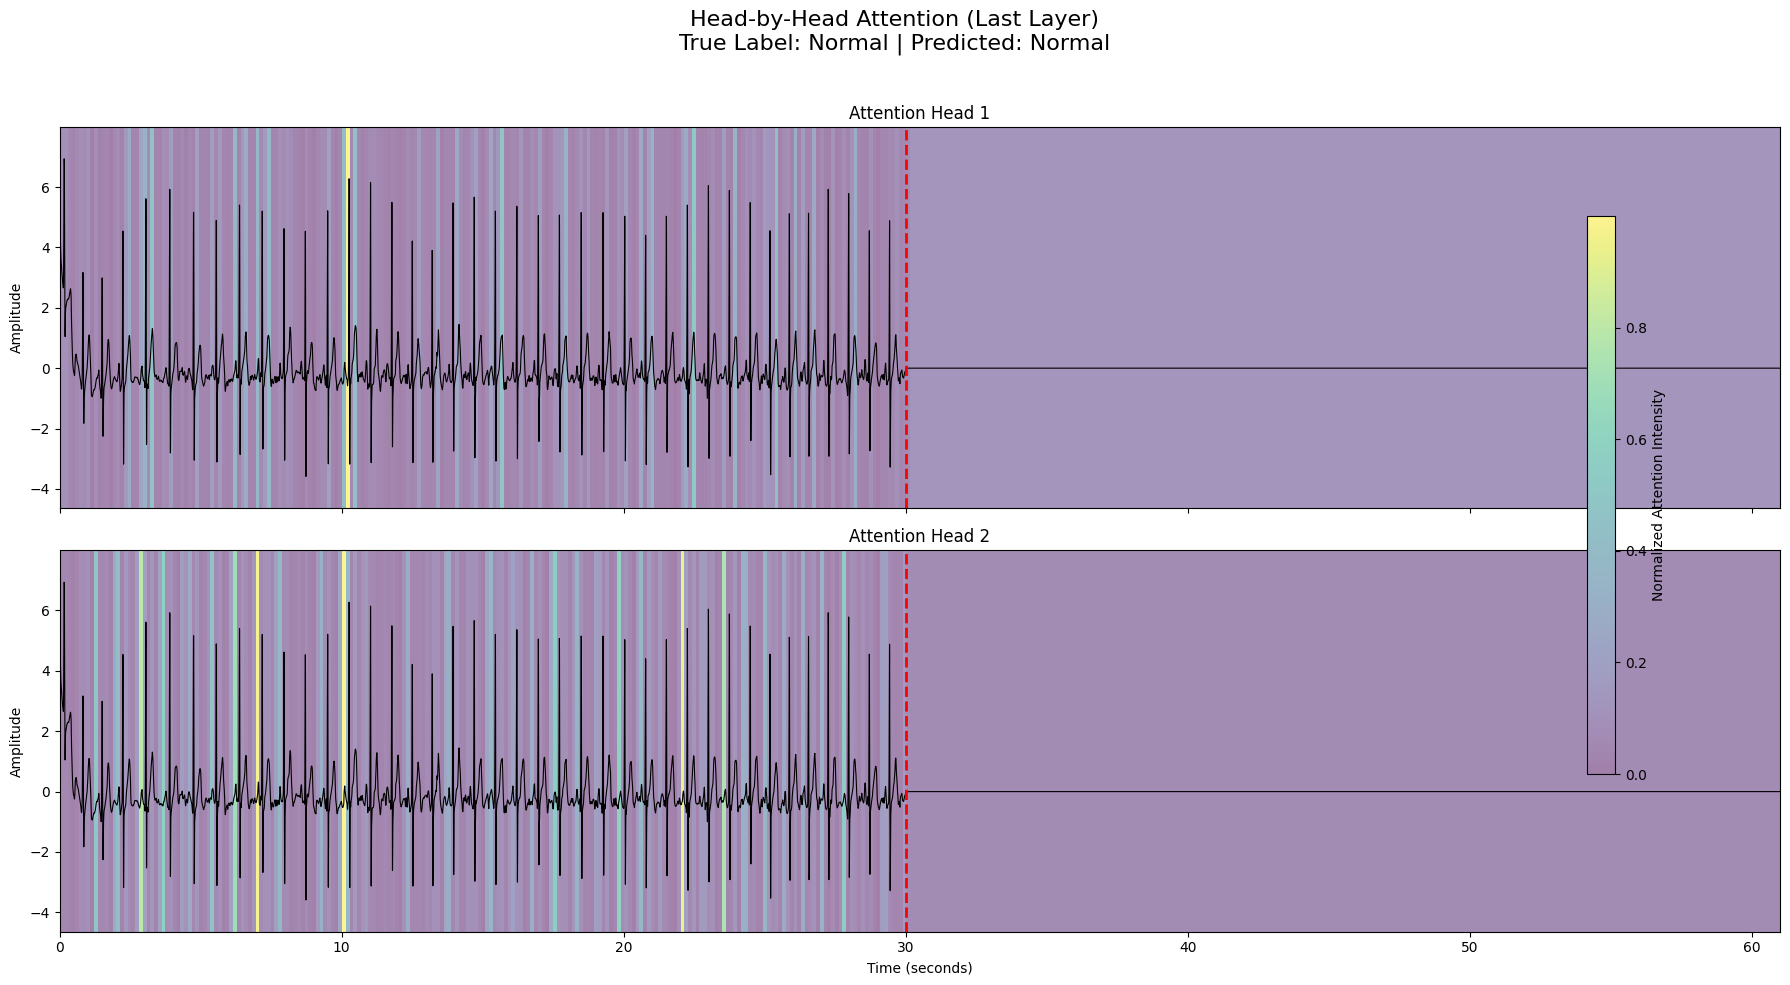

In [13]:
# ==============================================================
# 10 – INTERPRETABILITY: VISUALIZE ATTENTION HEAD-BY-HEAD (ENHANCED)
# ==============================================================

def plot_attention_by_head(model, ecg_signal, true_label, stride=40):
    """
    Visualizes the attention map for each individual head from the LAST layer
    using a background heatmap.
    """
    # --- 1. Get Prediction and Attention Scores ---
    ecg_signal_batch = np.expand_dims(ecg_signal, axis=0)
    
    # --- THIS IS THE KEY CHANGE ---
    # Unpack all 3 outputs and use the last one for the scores
    prediction, _, last_layer_scores = model.predict(ecg_signal_batch, verbose=0)
    
    # --- 2. Process Attention Scores (using last_layer_scores) ---
    num_heads = last_layer_scores.shape[1]
    squeezed_signal = ecg_signal.squeeze()
    
    # --- 3. Find End of Real Signal ---
    try:
        last_real_index = np.where(squeezed_signal != 0)[0][-1]
        end_of_signal_time = last_real_index / FS_TARGET
    except IndexError:
        end_of_signal_time = MAX_LEN_SEC

    # --- 4. Create the Plot ---
    predicted_class = "Arrhythmia" if prediction[0][0] > 0.5 else "Normal"
    true_class = "Arrhythmia" if true_label == 1 else "Normal"
    
    fig, axes = plt.subplots(num_heads, 1, figsize=(18, 5 * num_heads), sharex=True)
    if num_heads == 1:
        axes = [axes]
        
    fig.suptitle(
        f"Head-by-Head Attention (Last Layer)\n"
        f"True Label: {true_class} | Predicted: {predicted_class}",
        fontsize=16
    )
    
    time = np.arange(MAX_LEN) / FS_TARGET
    min_val, max_val = np.min(squeezed_signal), np.max(squeezed_signal)
    y_pad = (max_val - min_val) * 0.1

    for i in range(num_heads):
        ax = axes[i]
        
        # Use the scores from the last layer
        head_scores = last_layer_scores[0, i, :, :]
        patch_importance = np.mean(head_scores, axis=0)
        patch_importance_normalized = (patch_importance - np.min(patch_importance)) / (np.max(patch_importance) - np.min(patch_importance) + 1e-8)
        
        attention_heatmap = np.repeat(patch_importance_normalized, stride)
        attention_heatmap = attention_heatmap[:MAX_LEN]
        
        heatmap_2d = np.tile(attention_heatmap, (10, 1))
        im = ax.imshow(
            heatmap_2d,
            aspect='auto',
            cmap='viridis',
            interpolation='nearest',
            extent=[time[0], time[-1], min_val - y_pad, max_val + y_pad],
            alpha=0.5
        )
        
        ax.plot(time, squeezed_signal, color='black', linewidth=0.8)
        ax.axvline(x=end_of_signal_time, color='r', linestyle='--', linewidth=2)
        
        ax.set_ylabel('Amplitude')
        ax.set_title(f'Attention Head {i+1}')
        ax.set_xlim(0, MAX_LEN_SEC)

    fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.02).set_label('Normalized Attention Intensity')
    axes[-1].set_xlabel('Time (seconds)')
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Example Usage: Analyze Multiple Signals ---
# This part of the code does not need to change.
# It will automatically call the updated function above.
print("\n--- Running Head-by-Head Visualization for Multiple Samples ---")

# --- Visualize the first 3 Arrhythmia cases ---
arrhythmia_indices = np.where(y_te == 1)[0]
num_to_show = min(3, len(arrhythmia_indices))

if num_to_show > 0:
    for i in range(num_to_show):
        sample_idx = arrhythmia_indices[i]
        print(f"\nVisualizing Arrhythmia Sample #{i+1} (Test Index: {sample_idx})")
        plot_attention_by_head(model, X_te[sample_idx], y_te[sample_idx])
else:
    print("\nNo arrhythmia samples found in the test set to visualize.")

# --- Visualize the first 3 Normal cases ---
normal_indices = np.where(y_te == 0)[0]
num_to_show = min(3, len(normal_indices))

if num_to_show > 0:
    for i in range(num_to_show):
        sample_idx = normal_indices[i]
        print(f"\nVisualizing Normal Sample #{i+1} (Test Index: {sample_idx})")
        plot_attention_by_head(model, X_te[sample_idx], y_te[sample_idx])
else:
    print("\nNo normal samples found in the test set to visualize.")

Recalculating predictions to find misclassifications...

Found 70 misclassified samples in the test set.
Number of False Negatives (Missed Arrhythmias): 32
Number of False Positives (Incorrect Arrhythmia Alerts): 38

--- Visualizing False Negatives (Model missed these Arrhythmias) ---

Visualizing False Negative Sample #1 (Test Index: 36)


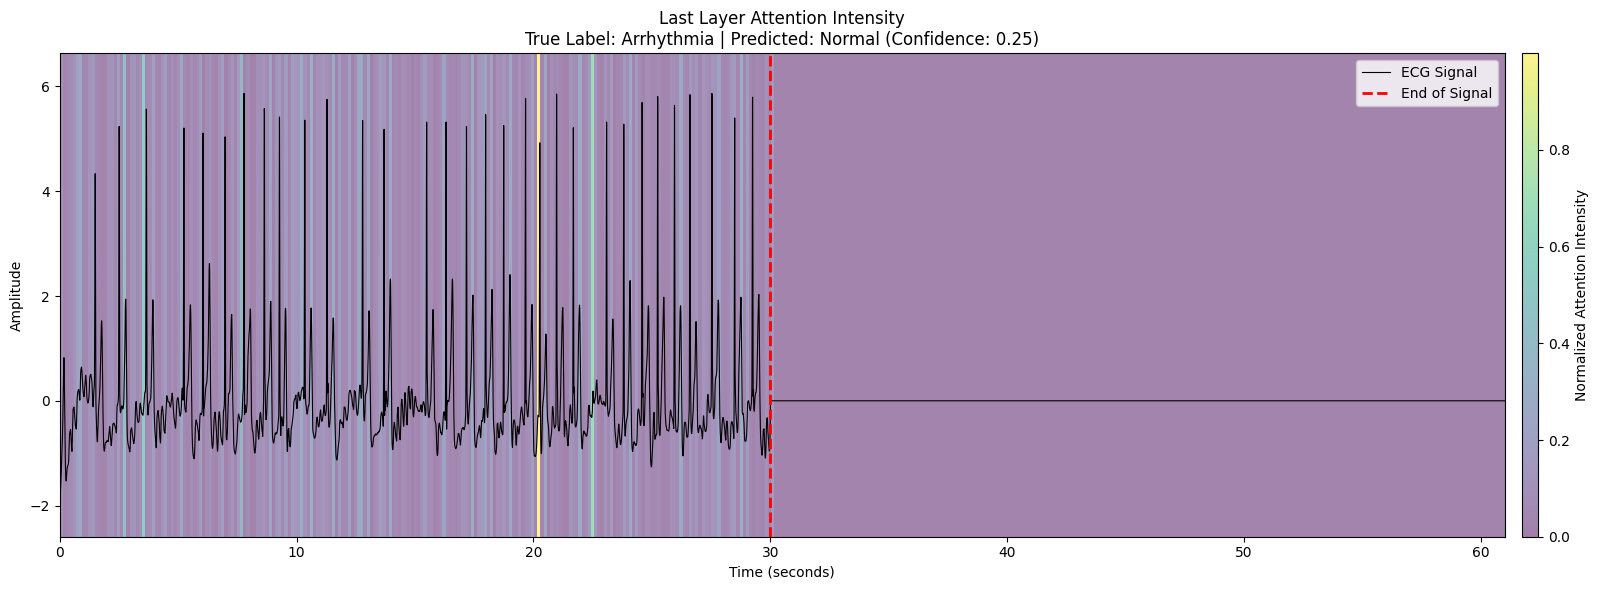


Visualizing False Negative Sample #2 (Test Index: 37)


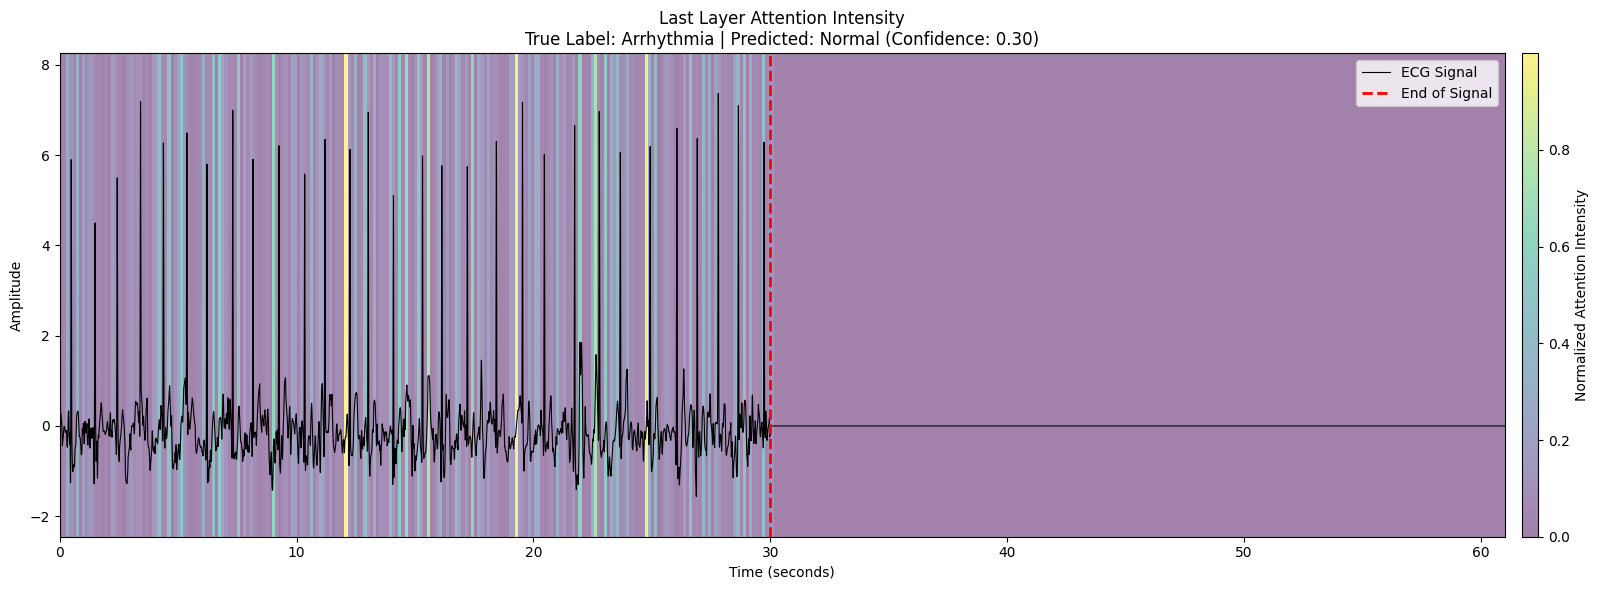


Visualizing False Negative Sample #3 (Test Index: 41)


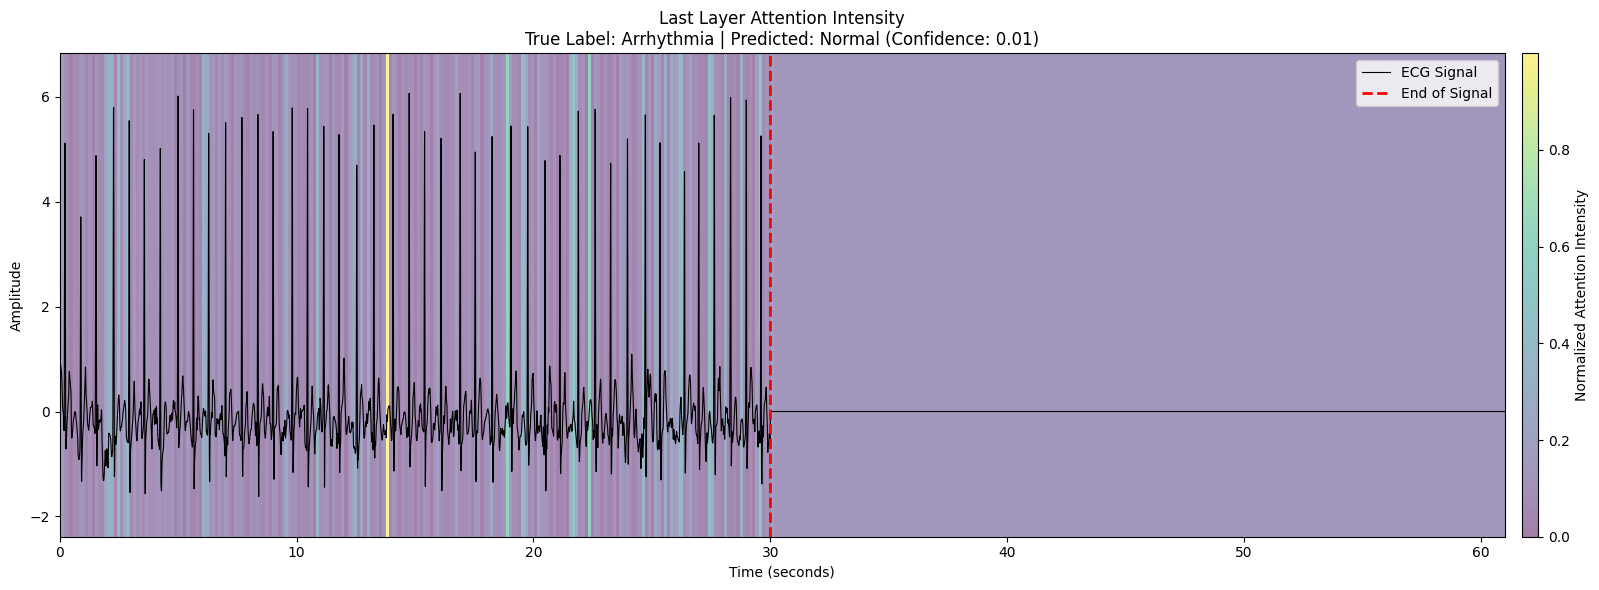


--- Visualizing False Positives (Model gave false alerts for these) ---

Visualizing False Positive Sample #1 (Test Index: 2)


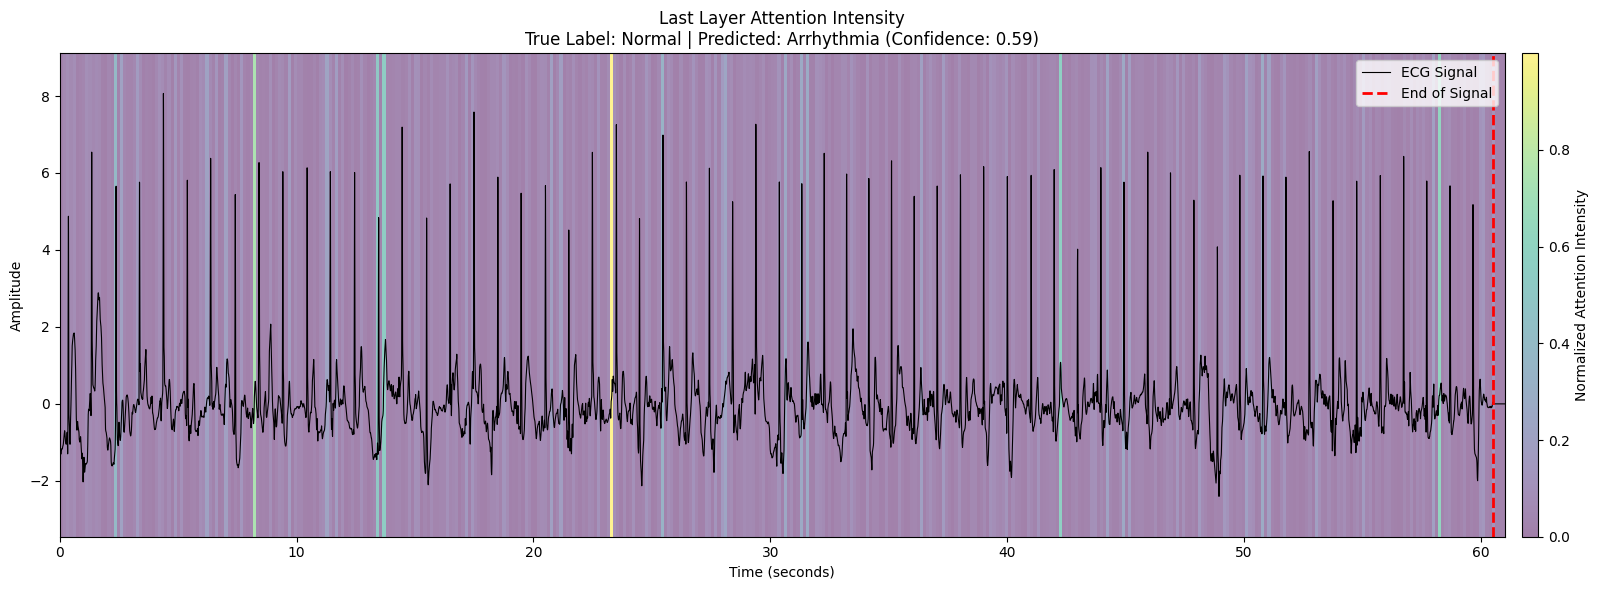


Visualizing False Positive Sample #2 (Test Index: 11)


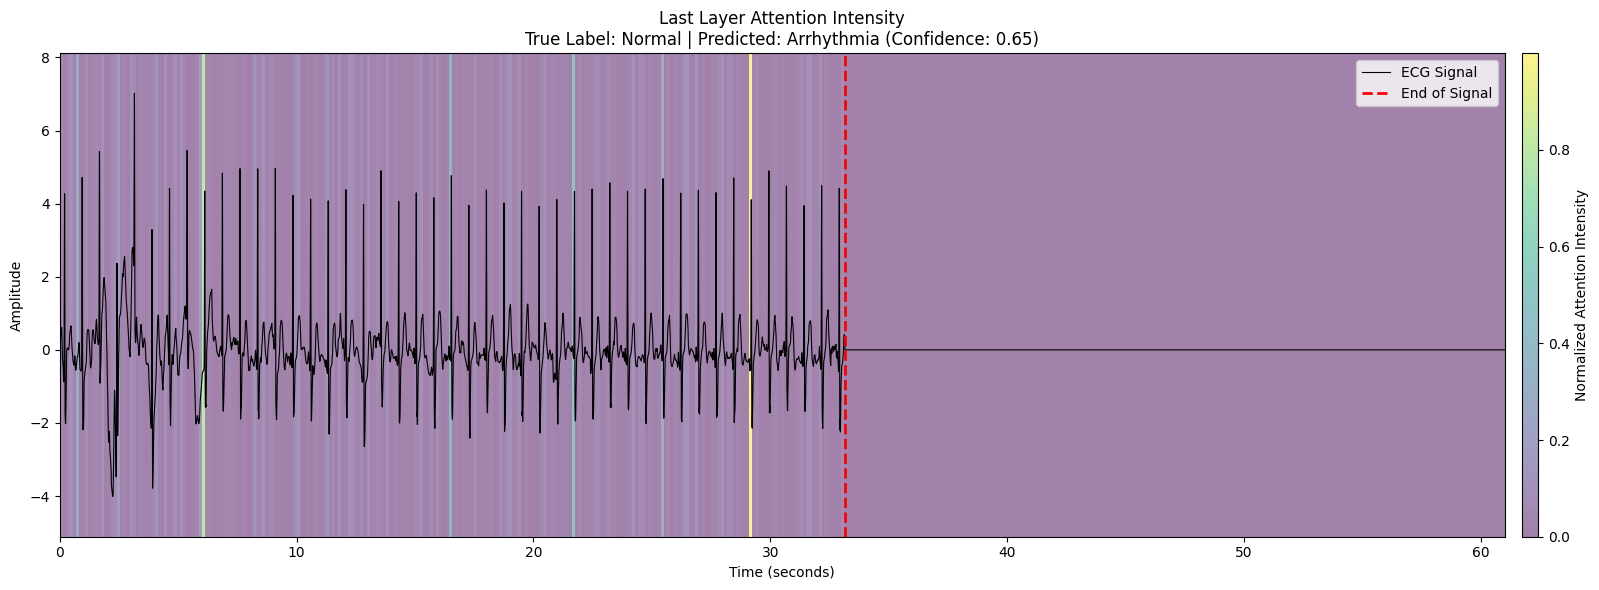


Visualizing False Positive Sample #3 (Test Index: 19)


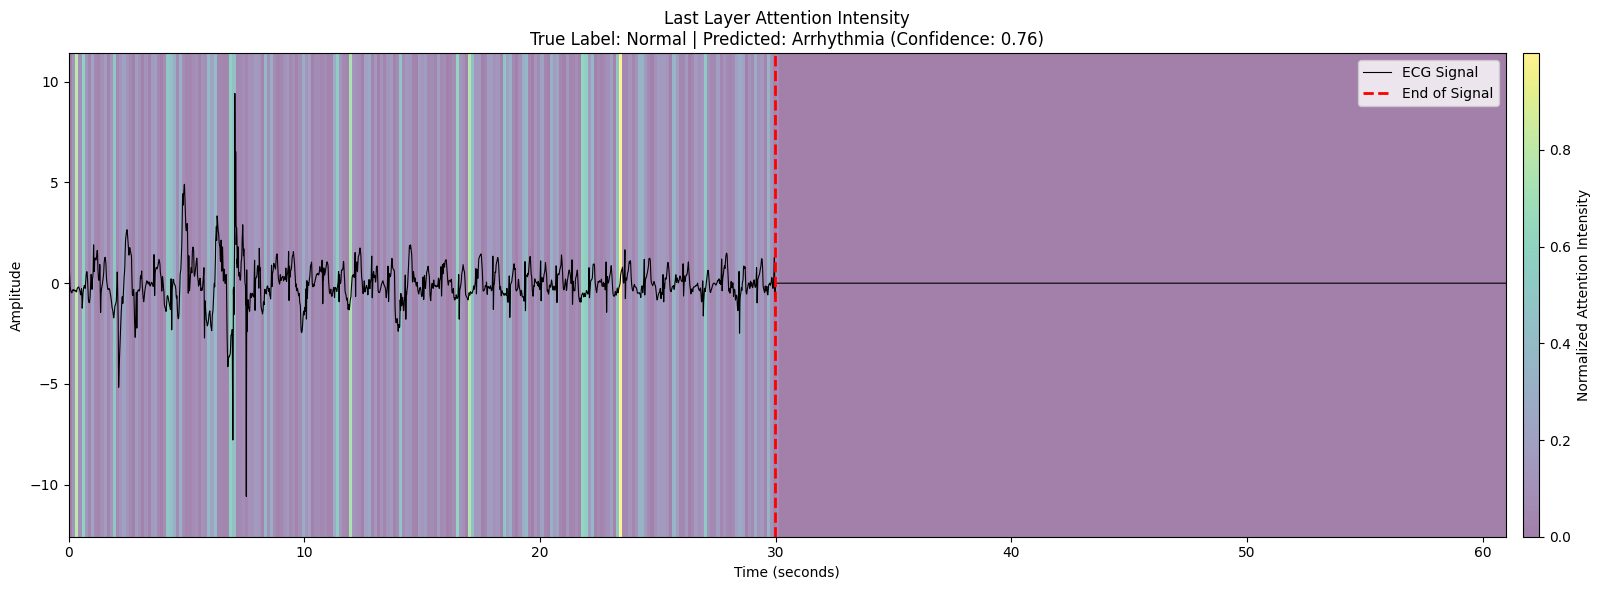

In [14]:
# ==============================================================
# 11 – INTERPRETABILITY: DEEP DIVE INTO MISCLASSIFICATIONS (ENHANCED)
# ==============================================================

# We need the predicted labels (y_pred) and true labels (y_te) from Section 7
# If you haven't run it recently, let's quickly recalculate them.
print("Recalculating predictions to find misclassifications...")

# --- THIS IS THE KEY CHANGE ---
# Unpack all 3 outputs from the model, but only use the first one (the prediction)
prediction_output, _, _ = model.predict(test_ds, verbose=0)
y_pred_prob = prediction_output.ravel()
y_pred = (y_pred_prob > 0.5).astype(int)


# --- Find the indices of all misclassified samples ---
misclassified_indices = np.where(y_pred != y_te)[0]
print(f"\nFound {len(misclassified_indices)} misclassified samples in the test set.")


# --- Separate into False Positives and False Negatives ---
fn_indices = np.where((y_pred == 0) & (y_te == 1))[0]
print(f"Number of False Negatives (Missed Arrhythmias): {len(fn_indices)}")

fp_indices = np.where((y_pred == 1) & (y_te == 0))[0]
print(f"Number of False Positives (Incorrect Arrhythmia Alerts): {len(fp_indices)}")


# --- Visualize a few examples of each error type ---
# Note: This part assumes you have already replaced the function definition for
# plot_attention_heatmap_intensity with the updated version that handles 3 outputs.

# Visualize False Negatives
print("\n--- Visualizing False Negatives (Model missed these Arrhythmias) ---")
num_to_show = min(3, len(fn_indices)) # Show up to 3 examples
if num_to_show > 0:
    for i in range(num_to_show):
        sample_idx = fn_indices[i]
        print(f"\nVisualizing False Negative Sample #{i+1} (Test Index: {sample_idx})")
        plot_attention_heatmap_intensity(model, X_te[sample_idx], y_te[sample_idx])
else:
    print("No False Negative errors to visualize.")


# Visualize False Positives
print("\n--- Visualizing False Positives (Model gave false alerts for these) ---")
num_to_show = min(3, len(fp_indices)) # Show up to 3 examples
if num_to_show > 0:
    for i in range(num_to_show):
        sample_idx = fp_indices[i]
        print(f"\nVisualizing False Positive Sample #{i+1} (Test Index: {sample_idx})")
        plot_attention_heatmap_intensity(model, X_te[sample_idx], y_te[sample_idx])
else:
    print("No False Positive errors to visualize.")

Found 135 correctly classified Arrhythmia samples (True Positives).
Found 141 correctly classified Normal samples (True Negatives).

--- Plotting Aggregate Attention Maps ---


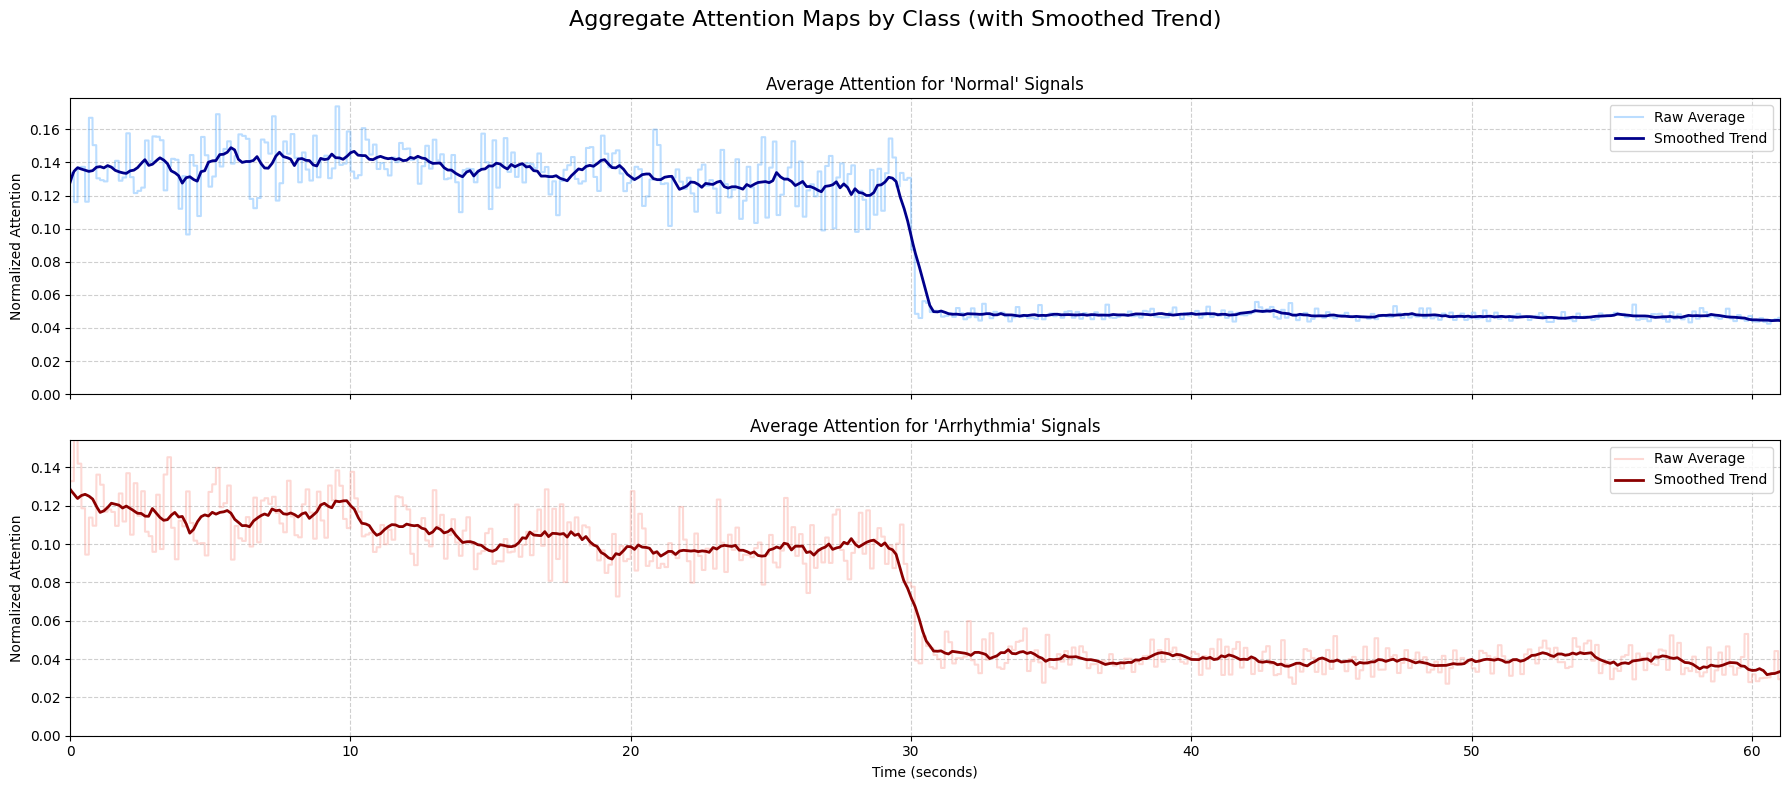

In [15]:
# ==============================================================
# 12 – INTERPRETABILITY: AGGREGATE ATTENTION MAPS
# ==============================================================

def get_attention_map(model, ecg_signal):
    """
    Helper function to calculate the normalized attention map for a single signal
    from the LAST transformer layer.
    """
    ecg_signal_batch = np.expand_dims(ecg_signal, axis=0)
    
    # --- THIS IS THE KEY CHANGE ---
    # Unpack 3 outputs and use the last one (last layer's attention)
    _, _, last_layer_scores = model.predict(ecg_signal_batch, verbose=0)
    
    avg_attention_scores = np.mean(last_layer_scores[0], axis=0)
    patch_importance = np.mean(avg_attention_scores, axis=0)
    
    # Normalize for consistent scaling across all maps
    patch_importance_normalized = (patch_importance - np.min(patch_importance)) / (np.max(patch_importance) - np.min(patch_importance) + 1e-8)
    
    return patch_importance_normalized

# --- Find correctly classified samples ---
# Note: This requires y_pred to be calculated from the new model in Section 7/11
tp_indices = np.where((y_pred == 1) & (y_te == 1))[0]
print(f"Found {len(tp_indices)} correctly classified Arrhythmia samples (True Positives).")

tn_indices = np.where((y_pred == 0) & (y_te == 0))[0]
print(f"Found {len(tn_indices)} correctly classified Normal samples (True Negatives).")


# --- Calculate aggregate attention for each class ---

# Aggregate for Arrhythmia (TP)
arrhythmia_attention_maps = []
if len(tp_indices) > 0:
    for idx in tp_indices:
        attention_map = get_attention_map(model, X_te[idx])
        arrhythmia_attention_maps.append(attention_map)
    aggregate_arrhythmia_map = np.mean(arrhythmia_attention_maps, axis=0)
else:
    aggregate_arrhythmia_map = None
    print("No True Positives to create an aggregate map.")

# Aggregate for Normal (TN)
normal_attention_maps = []
if len(tn_indices) > 0:
    for idx in tn_indices:
        attention_map = get_attention_map(model, X_te[idx])
        normal_attention_maps.append(attention_map)
    aggregate_normal_map = np.mean(normal_attention_maps, axis=0)
else:
    aggregate_normal_map = None
    print("No True Negatives to create an aggregate map.")


# --- Plot the aggregate maps for comparison (ENHANCED WITH SMOOTHING) ---

def plot_aggregate_maps(agg_normal, agg_arrhythmia, stride=40, smoothing_window=10):
    """
    Plots the aggregate attention maps with a smoothed trendline
    to make underlying patterns clearer.
    """
    fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True)
    fig.suptitle("Aggregate Attention Maps by Class (with Smoothed Trend)", fontsize=16)
    
    time = np.arange(MAX_LEN) / FS_TARGET
    
    # --- Plot Normal Map ---
    if agg_normal is not None:
        ax1 = axes[0]
        heatmap_normal = np.repeat(agg_normal, stride)[:MAX_LEN]
        
        s_normal = pd.Series(heatmap_normal)
        smoothed_normal = s_normal.rolling(window=smoothing_window * stride, min_periods=1, center=True).mean()
        
        ax1.plot(time, heatmap_normal, color='dodgerblue', alpha=0.3, label='Raw Average')
        ax1.plot(time, smoothed_normal, color='darkblue', linewidth=2, label='Smoothed Trend')
        
        ax1.set_title("Average Attention for 'Normal' Signals")
        ax1.set_ylabel("Normalized Attention")
        ax1.set_ylim(0, max(np.max(smoothed_normal) * 1.2, 0.1))
        ax1.grid(True, linestyle='--', alpha=0.6)
        ax1.legend()

    # --- Plot Arrhythmia Map ---
    if agg_arrhythmia is not None:
        ax2 = axes[1]
        heatmap_arrhythmia = np.repeat(agg_arrhythmia, stride)[:MAX_LEN]
        
        s_arrhythmia = pd.Series(heatmap_arrhythmia)
        smoothed_arrhythmia = s_arrhythmia.rolling(window=smoothing_window * stride, min_periods=1, center=True).mean()

        ax2.plot(time, heatmap_arrhythmia, color='salmon', alpha=0.3, label='Raw Average')
        ax2.plot(time, smoothed_arrhythmia, color='darkred', linewidth=2, label='Smoothed Trend')

        ax2.set_title("Average Attention for 'Arrhythmia' Signals")
        ax2.set_ylabel("Normalized Attention")
        ax2.set_ylim(0, max(np.max(smoothed_arrhythmia) * 1.2, 0.1))
        ax2.grid(True, linestyle='--', alpha=0.6)
        ax2.legend()

    plt.xlabel("Time (seconds)")
    plt.xlim(0, MAX_LEN_SEC)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

print("\n--- Plotting Aggregate Attention Maps ---")
plot_aggregate_maps(aggregate_normal_map, aggregate_arrhythmia_map)


--- Comparing Attention Across Layers ---

Visualizing Arrhythmia Sample (Test Index: 0)


/var/folders/hl/n8ld50fn44bgmz1x9g35k1800000gn/T/ipykernel_86393/2565576511.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])


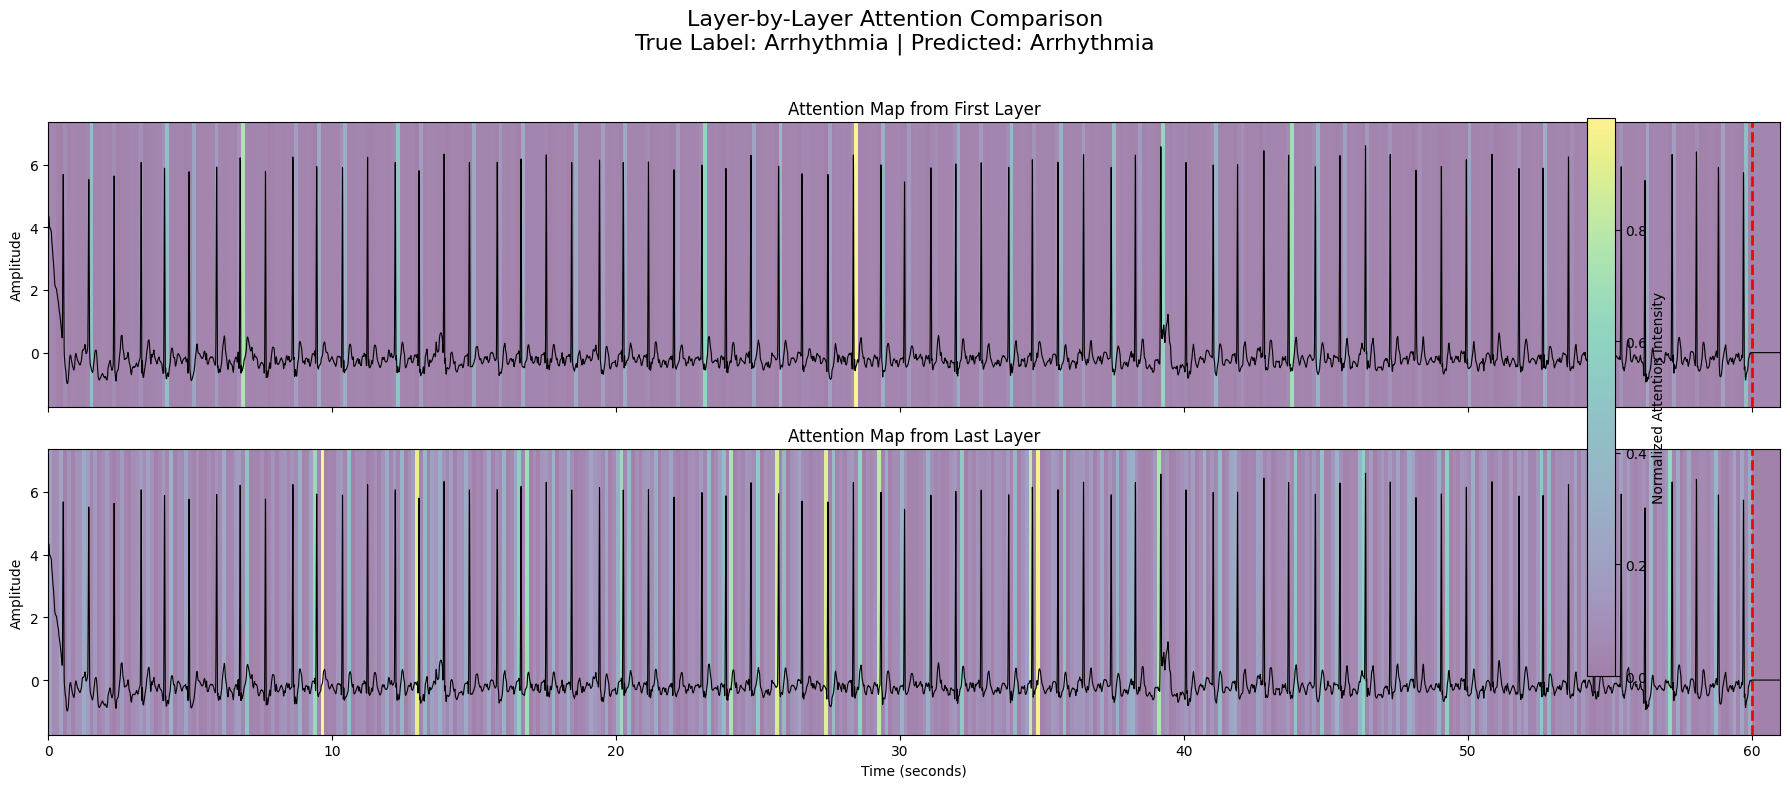

In [16]:
# ==============================================================
# 13 – INTERPRETABILITY: COMPARE ATTENTION ACROSS LAYERS
# ==============================================================

def plot_layer_attention_comparison(model, ecg_signal, true_label, stride=40):
    """
    Visualizes and compares the attention maps from the first and last
    transformer blocks.
    """
    ecg_signal_batch = np.expand_dims(ecg_signal, axis=0)
    # --- PREDICT: Unpack 3 outputs ---
    prediction, first_layer_scores, last_layer_scores = model.predict(ecg_signal_batch, verbose=0)
    
    attention_maps = {
        "First Layer": first_layer_scores,
        "Last Layer": last_layer_scores
    }
    
    squeezed_signal = ecg_signal.squeeze()
    try:
        last_real_index = np.where(squeezed_signal != 0)[0][-1]
        end_of_signal_time = last_real_index / FS_TARGET
    except IndexError:
        end_of_signal_time = MAX_LEN_SEC

    predicted_class = "Arrhythmia" if prediction[0][0] > 0.5 else "Normal"
    true_class = "Arrhythmia" if true_label == 1 else "Normal"
    
    fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True)
    fig.suptitle(
        f"Layer-by-Layer Attention Comparison\n"
        f"True Label: {true_class} | Predicted: {predicted_class}",
        fontsize=16
    )
    
    time = np.arange(MAX_LEN) / FS_TARGET
    min_val, max_val = np.min(squeezed_signal), np.max(squeezed_signal)
    y_pad = (max_val - min_val) * 0.1

    for i, (layer_name, scores) in enumerate(attention_maps.items()):
        ax = axes[i]
        
        # Process scores for the current layer
        avg_scores = np.mean(scores[0], axis=0)
        patch_importance = np.mean(avg_scores, axis=0)
        patch_importance_normalized = (patch_importance - np.min(patch_importance)) / (np.max(patch_importance) - np.min(patch_importance) + 1e-8)
        
        attention_heatmap = np.repeat(patch_importance_normalized, stride)[:MAX_LEN]
        heatmap_2d = np.tile(attention_heatmap, (10, 1))
        
        # Plot background heatmap
        im = ax.imshow(
            heatmap_2d, aspect='auto', cmap='viridis', interpolation='nearest',
            extent=[time[0], time[-1], min_val - y_pad, max_val + y_pad], alpha=0.5
        )
        
        # Plot signal on top
        ax.plot(time, squeezed_signal, color='black', linewidth=0.8)
        ax.axvline(x=end_of_signal_time, color='r', linestyle='--', linewidth=2)
        
        ax.set_ylabel('Amplitude')
        ax.set_title(f"Attention Map from {layer_name}")
        ax.set_xlim(0, MAX_LEN_SEC)

    fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.02).set_label('Normalized Attention Intensity')
    axes[-1].set_xlabel('Time (seconds)')
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Example Usage ---
print("\n--- Comparing Attention Across Layers ---")
# Let's look at an arrhythmia case to see how focus evolves
arrhythmia_indices = np.where(y_te == 1)[0]
if len(arrhythmia_indices) > 0:
    sample_idx = arrhythmia_indices[0]
    print(f"\nVisualizing Arrhythmia Sample (Test Index: {sample_idx})")
    plot_layer_attention_comparison(model, X_te[sample_idx], y_te[sample_idx])
else:
    print("\nNo arrhythmia samples found to visualize.")